<a href="https://colab.research.google.com/github/Abdou-ch-d/Breast-Cancer-Detection/blob/main/TrainCustomYolov3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Tue Jun  7 09:01:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-d75d0b39-e469-258d-12e2-d28799b44741)


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


#**Pakages**

In [ ]:
%%capture
!pip install -U albumentations

In [ ]:
%%capture
!pip install pydicom

In [ ]:
%%capture
!pip install --force-reinstall albumentations==1.0.3

In [ ]:
%%capture
!pip install SimpleITK

In [ ]:
%%capture
!pip install --force-reinstall opencv-python-headless==4.1.2.30

In [ ]:
%%capture
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

In [ ]:
%%capture
!pip install split-folders

In [ ]:
%%capture
!pip install import_ipynb

In [ ]:
%%capture
!pip install --upgrade --force-reinstall opencv-python-headless==4.1.2.30

In [ ]:
exit()

#Data zip

In [ ]:
import os
!pwd
os.chdir('/content')
!pwd

/content
/content


In [ ]:
!rm -r '/content/Datasets'
# !rm -r '/content/Data'

rm: cannot remove '/content/Datasets': No such file or directory


In [ ]:
# !unzip '/content/drive/MyDrive/INBreast_Dataset/Micros_Dataset.zip' -d '/content/'

In [ ]:
# !cp -v '/content/content/Inbreast_data' -r 'Dataset'
# !rm -r '/content/Dataset/AllOriginals'
# !mv '/content/Dataset/AllSynthetized' '/content/Dataset/images'
# !mv '/content/Dataset/AllMasks' '/content/Dataset/masks'

In [ ]:
%%capture
                              ## Original INBreast
!unzip '/content/drive/MyDrive/INBreast_Dataset/INbreast Release 1.0.zip' -d '/content/Datasets'

# Bib

In [ ]:
# !pip install --upgrade tensorflow
# !pip install --upgrade tensorflow-gpu

In [ ]:
import os
!pwd
os.chdir('/content/drive/MyDrive/Colab Notebooks')
!pwd    

/content
/content/drive/MyDrive/Colab Notebooks


In [ ]:
import tensorflow as tf
import numpy as np
import time
import os
import cv2
import random 
import colorsys
from matplotlib.colors import LinearSegmentedColormap
import glob
from tqdm.notebook import tqdm, trange
import albumentations as A

In [ ]:
from keras.models import Model,Sequential,load_model
from keras.layers import Conv2D, Add, ZeroPadding2D, UpSampling2D, Concatenate, MaxPooling2D,Activation,Dropout,Flatten,Conv2D,MaxPooling2D,Dense,Input, Lambda,Input
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras import regularizers 
from tensorflow.keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from tensorflow.keras.utils import Sequence
from keras import backend as K
from functools import reduce
from keras.models import Model
import pydicom as dicom
from PIL import Image 
import matplotlib.pyplot as plt 
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from functools import reduce

In [ ]:
from kerasYolov3  import  box_iou,preprocess_true_boxes,yolo_eval,control_flow_ops
# from Kerasyolo import yolo_loss* 

In [ ]:
os.chdir('/content')
source_path_file = '/content/drive/MyDrive/Colab Notebooks/pre_train.ipynb'
source_path_file = source_path_file.replace(' ', '\\ ')
!cp $source_path_file '/content' # to copy the file from drive to colab
# run this line to sync with the parent file in case you made any changes
!rsync -aP $source_path_file '/content/pre_train.ipynb'

source_path_file = '/content/drive/MyDrive/Colab Notebooks/Dicom_Preprocessing.ipynb'
source_path_file = source_path_file.replace(' ', '\\ ')
!cp $source_path_file '/content' # to copy the file from drive to colab
# run this line to sync with the parent file in case you made any changes
!rsync -aP $source_path_file '/content/Dicom_Preprocessing.ipynb'


import import_ipynb
from pre_train import PreProcessing, Pad_mask
from Dicom_Preprocessing import PreprocessDicom,mask_to_yolo

sending incremental file list
pre_train.ipynb
        556,578 100%   49.95MB/s    0:00:00 (xfr#1, to-chk=0/1)
sending incremental file list
Dicom_Preprocessing.ipynb
         33,584 100%  796.88kB/s    0:00:00 (xfr#1, to-chk=0/1)
importing Jupyter notebook from pre_train.ipynb
importing Jupyter notebook from Dicom_Preprocessing.ipynb


# Model builder
residual skip connections, and upsampling

##Body Layers 

Darknet + ResNet as the base model: The new Darknet-53 still relies on successive 3x3 and 1x1 conv layers, just like the original dark net architecture, but has residual blocks added.

Compose arbitrarily many functions, evaluated left to right.

In [ ]:
def compose(*funcs):
    if funcs:
        return reduce(lambda f, g: lambda *a, **kw: g(f(*a, **kw)), funcs)
    else:
        raise ValueError('Composition of empty sequence not supported.')

Wrapper to set Darknet parameters for Convolution2D

In [ ]:
def DarknetConv2D(*args, **kwargs):
    darknet_conv_kwargs = {'kernel_regularizer': regularizers.l2(5e-4)}#l2(5e-4)}
    darknet_conv_kwargs['padding'] = 'valid' if kwargs.get('strides')==(2,2) else 'same'
    darknet_conv_kwargs.update(kwargs)
    return Conv2D(*args, **darknet_conv_kwargs)

In [ ]:
def DarknetConv2D_BN_Leaky(*args, **kwargs):
    no_bias_kwargs = {'use_bias': False}
    no_bias_kwargs.update(kwargs)
    return compose(
        DarknetConv2D(*args, **no_bias_kwargs),
        BatchNormalization(),
        LeakyReLU(alpha=0.1))

A series of resblocks starting with a downsampling Convolution2D

Darknet uses left and top padding instead of 'same' mode

In [ ]:
def resblock_body(x, num_filters, num_blocks):
    x = ZeroPadding2D(((1,0),(1,0)))(x)
    x = DarknetConv2D_BN_Leaky(num_filters, (3,3), strides=(2,2))(x)
    for i in range(num_blocks):
        y = compose(
                DarknetConv2D_BN_Leaky(num_filters//2, (1,1)),
                DarknetConv2D_BN_Leaky(num_filters, (3,3)))(x)
        x = Add()([x,y])
    return x

Darknent body having 52 Convolution2D layers

In [ ]:
def darknet_body(x):
    x = DarknetConv2D_BN_Leaky(32, (3,3))(x)
    x = resblock_body(x, 64, 1)
    x = resblock_body(x, 128, 2)
    x = resblock_body(x, 256, 8)
    x = resblock_body(x, 512, 8)
    x = resblock_body(x, 1024, 4)
    return x

6 Conv2D_BN_Leaky layers followed by a Conv2D_linear layer

In [ ]:
def make_last_layers(x, num_filters, out_filters):
    x = compose(
            DarknetConv2D_BN_Leaky(num_filters, (1,1)),
            DarknetConv2D_BN_Leaky(num_filters*2, (3,3)),
            DarknetConv2D_BN_Leaky(num_filters, (1,1)),
            DarknetConv2D_BN_Leaky(num_filters*2, (3,3)),
            DarknetConv2D_BN_Leaky(num_filters, (1,1)))(x)
    y = compose(
            DarknetConv2D_BN_Leaky(num_filters*2, (3,3)),
            DarknetConv2D(out_filters, (1,1)))(x)
    return x, y

**Create YOLO_V3 model CNN body in Keras**

In [ ]:
def yolo_body(inputs, num_anchors, num_classes):
    darknet = Model(inputs, darknet_body(inputs))
    x, y1 = make_last_layers(darknet.output, 512, num_anchors*(num_classes+5))

    x = compose(
            DarknetConv2D_BN_Leaky(256, (1,1)),
            UpSampling2D(2))(x)
    x = Concatenate()([x,darknet.layers[152].output])
    x, y2 = make_last_layers(x, 256, num_anchors*(num_classes+5))

    x = compose(
            DarknetConv2D_BN_Leaky(128, (1,1)),
            UpSampling2D(2))(x)
    x = Concatenate()([x,darknet.layers[92].output])
    x, y3 = make_last_layers(x, 128, num_anchors*(num_classes+5))

    return Model(inputs, [y1,y2,y3])

**MobileNet_featur extractor**

In [ ]:
from keras.applications.mobilenet import MobileNet
def yolo_body_MobileNet(inputs, num_anchors, num_classes):
    mobilenet = MobileNet(input_tensor=inputs,weights='imagenet')

    f1 = mobilenet.get_layer('conv_pw_13_relu').output
    # f1 :13 x 13 x 1024
    x, y1 = make_last_layers(f1, 512, num_anchors * (num_classes + 5))
    x = compose(
            DarknetConv2D_BN_Leaky(256, (1,1)),
            UpSampling2D(2))(x)

    f2 = mobilenet.get_layer('conv_pw_11_relu').output
    # f2: 26 x 26 x 512
    x = Concatenate()([x,f2])

    x, y2 = make_last_layers(x, 256, num_anchors*(num_classes+5))
    x = compose(
            DarknetConv2D_BN_Leaky(128, (1,1)),
            UpSampling2D(2))(x)

    f3 = mobilenet.get_layer('conv_pw_5_relu').output
    # f3 : 52 x 52 x 256
    x = Concatenate()([x, f3])
    x, y3 = make_last_layers(x, 128, num_anchors*(num_classes+5))

    return Model(inputs = inputs, outputs=[y1,y2,y3])

**Convert final layer features to bounding box parameters**

In [ ]:
def yolo_head(feats, anchors, num_classes, input_shape, calc_loss=False):
    num_anchors = len(anchors)
    # Reshape to batch, height, width, num_anchors, box_params.
    anchors_tensor = K.reshape(K.constant(anchors), [1, 1, 1, num_anchors, 2])

    grid_shape = K.shape(feats)[1:3] # height, width
    grid_y = K.tile(K.reshape(K.arange(0, stop=grid_shape[0]), [-1, 1, 1, 1]),
        [1, grid_shape[1], 1, 1])
    grid_x = K.tile(K.reshape(K.arange(0, stop=grid_shape[1]), [1, -1, 1, 1]),
        [grid_shape[0], 1, 1, 1])
    grid = K.concatenate([grid_x, grid_y])
    grid = K.cast(grid, K.dtype(feats))

    feats = K.reshape(
        feats, [-1, grid_shape[0], grid_shape[1], num_anchors, num_classes + 5])

    # Adjust preditions to each spatial grid point and anchor size.
    box_xy = (K.sigmoid(feats[..., :2]) + grid) / K.cast(grid_shape[::-1], K.dtype(feats))
    box_wh = K.exp(feats[..., 2:4]) * anchors_tensor / K.cast(input_shape[::-1], K.dtype(feats))
    box_confidence = K.sigmoid(feats[..., 4:5])
    box_class_probs = K.sigmoid(feats[..., 5:])

    if calc_loss == True:
        return grid, feats, box_xy, box_wh
    return box_xy, box_wh, box_confidence, box_class_probs

##**Yolo loss**

 Example: Imagine you have three classes with **label_smoothing** factor as 0.3.

 Then, new_labels according to the above formula will be:

 = [0 1 2] * (1– 0.3) + ( 0.3 / 3 )

 = [0 1 2] * (0.7 )+ 0.1 = [ 0.1 0.8 1.5 ]
 Now, the new labels will be [0.1 0.8 1.5] instead of [0 1 2]

In [ ]:
from re import T
import math
import tensorflow as tf
from tensorflow.keras import backend as K 

def yolo3_decode(feats, anchors, num_classes, input_shape, scale_x_y=None, calc_loss=False):
   
    num_anchors = len(anchors)
    # Reshape to batch, height, width, num_anchors, box_params.
    anchors_tensor = K.reshape(K.constant(anchors), [1, 1, 1, num_anchors, 2])

    grid_shape = K.shape(feats)[1:3] # height, width
    grid_y = K.tile(K.reshape(K.arange(0, stop=grid_shape[0]), [-1, 1, 1, 1]),
        [1, grid_shape[1], 1, 1])
    grid_x = K.tile(K.reshape(K.arange(0, stop=grid_shape[1]), [1, -1, 1, 1]),
        [grid_shape[0], 1, 1, 1])
    grid = K.concatenate([grid_x, grid_y])
    grid = K.cast(grid, K.dtype(feats))

    feats = K.reshape(
        feats, [-1, grid_shape[0], grid_shape[1], num_anchors, num_classes + 5])

    # Adjust preditions to each spatial grid point and anchor size.
    if scale_x_y:
        box_xy_tmp = K.sigmoid(feats[..., :2]) * scale_x_y - (scale_x_y - 1) / 2
        box_xy = (box_xy_tmp + grid) / K.cast(grid_shape[..., ::-1], K.dtype(feats))
    else:
        box_xy = (K.sigmoid(feats[..., :2]) + grid) / K.cast(grid_shape[..., ::-1], K.dtype(feats))
    box_wh = K.exp(feats[..., 2:4]) * anchors_tensor / K.cast(input_shape[..., ::-1], K.dtype(feats))
    box_confidence = K.sigmoid(feats[..., 4:5])
    box_class_probs = K.sigmoid(feats[..., 5:])

    if calc_loss == True:
        return grid, feats, box_xy, box_wh
    return box_xy, box_wh, box_confidence, box_class_probs



def softmax_focal_loss(y_true, y_pred, gamma=2.5, alpha=0.25):    #gamma=2
    #  alpha:  Weighting factor in range (0,1) to balance positive vs negative examples or -1 for ignore. 
    #  gamma: Exponent of the modulating factor (1 - p_t) to balance easy vs hard examples.
    y_pred = tf.nn.softmax(y_pred)
    y_pred = tf.maximum(tf.minimum(y_pred, 1 - 1e-15), 1e-15)
   
    # Calculate Cross Entropy
    cross_entropy = -y_true * tf.math.log(y_pred)
   
    # Calculate Focal Loss
    softmax_focal_loss = alpha * tf.pow(1 - y_pred, gamma) * cross_entropy

    return softmax_focal_loss


def sigmoid_focal_loss(y_true, y_pred, gamma=2.5, alpha=0.25):
  #  alpha:  Weighting factor in range (0,1) to balance positive vs negative examples or -1 for ignore. 
  #  gamma: Exponent of the modulating factor (1 - p_t) to balance easy vs hard examples.
  
    sigmoid_loss = K.binary_crossentropy(y_true, y_pred, from_logits=True)

    pred_prob = tf.sigmoid(y_pred)
    p_t = ((y_true * pred_prob) + ((1 - y_true) * (1 - pred_prob)))
    modulating_factor = tf.pow(1.0 - p_t, gamma)
    alpha_weight_factor = (y_true * alpha + (1 - y_true) * (1 - alpha))

    sigmoid_focal_loss = modulating_factor * alpha_weight_factor * sigmoid_loss
    sigmoid_focal_loss = tf.reduce_sum(sigmoid_focal_loss, axis=-1)

    return sigmoid_focal_loss



def box_iou(b1, b2):
   
    # Expand dim to apply broadcasting.
    b1 = K.expand_dims(b1, -2)
    b1_xy = b1[..., :2]
    b1_wh = b1[..., 2:4]
    b1_wh_half = b1_wh/2.
    b1_mins = b1_xy - b1_wh_half
    b1_maxes = b1_xy + b1_wh_half

    # Expand dim to apply broadcasting.
    b2 = K.expand_dims(b2, 0)
    b2_xy = b2[..., :2]
    b2_wh = b2[..., 2:4]
    b2_wh_half = b2_wh/2.
    b2_mins = b2_xy - b2_wh_half
    b2_maxes = b2_xy + b2_wh_half

    intersect_mins = K.maximum(b1_mins, b2_mins)
    intersect_maxes = K.minimum(b1_maxes, b2_maxes)
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]
    b1_area = b1_wh[..., 0] * b1_wh[..., 1]
    b2_area = b2_wh[..., 0] * b2_wh[..., 1]
    iou = intersect_area / (b1_area + b2_area - intersect_area)

    return iou


def box_giou(b_true, b_pred):
    """
        "Generalized Iou: A Metric and A Loss for Bounding Box Regression"
    """
    b_true_xy = b_true[..., :2]
    b_true_wh = b_true[..., 2:4]
    b_true_wh_half = b_true_wh/2.
    b_true_mins = b_true_xy - b_true_wh_half
    b_true_maxes = b_true_xy + b_true_wh_half

    b_pred_xy = b_pred[..., :2]
    b_pred_wh = b_pred[..., 2:4]
    b_pred_wh_half = b_pred_wh/2.
    b_pred_mins = b_pred_xy - b_pred_wh_half
    b_pred_maxes = b_pred_xy + b_pred_wh_half

    intersect_mins = K.maximum(b_true_mins, b_pred_mins)
    intersect_maxes = K.minimum(b_true_maxes, b_pred_maxes)
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]
    b_true_area = b_true_wh[..., 0] * b_true_wh[..., 1]
    b_pred_area = b_pred_wh[..., 0] * b_pred_wh[..., 1]
    union_area = b_true_area + b_pred_area - intersect_area
    # calculate IoU, add epsilon in denominator to avoid dividing by 0
    iou = intersect_area / (union_area + K.epsilon())

    # get enclosed area
    enclose_mins = K.minimum(b_true_mins, b_pred_mins)
    enclose_maxes = K.maximum(b_true_maxes, b_pred_maxes)
    enclose_wh = K.maximum(enclose_maxes - enclose_mins, 0.0)
    enclose_area = enclose_wh[..., 0] * enclose_wh[..., 1]
    # calculate GIoU, add epsilon in denominator to avoid dividing by 0
    giou = iou - 1.0 * (enclose_area - union_area) / (enclose_area + K.epsilon())
    giou = K.expand_dims(giou, -1)

    return giou


def box_diou(b_true, b_pred, use_ciou=False):
    """
        "Distance-IoU Loss: Faster and Better Learning for Bounding Box Regression"
    """
    b_true_xy = b_true[..., :2]
    b_true_wh = b_true[..., 2:4]
    b_true_wh_half = b_true_wh/2.
    b_true_mins = b_true_xy - b_true_wh_half
    b_true_maxes = b_true_xy + b_true_wh_half

    b_pred_xy = b_pred[..., :2]
    b_pred_wh = b_pred[..., 2:4]
    b_pred_wh_half = b_pred_wh/2.
    b_pred_mins = b_pred_xy - b_pred_wh_half
    b_pred_maxes = b_pred_xy + b_pred_wh_half

    intersect_mins = K.maximum(b_true_mins, b_pred_mins)
    intersect_maxes = K.minimum(b_true_maxes, b_pred_maxes)
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]
    b_true_area = b_true_wh[..., 0] * b_true_wh[..., 1]
    b_pred_area = b_pred_wh[..., 0] * b_pred_wh[..., 1]
    union_area = b_true_area + b_pred_area - intersect_area
    # calculate IoU, add epsilon in denominator to avoid dividing by 0
    iou = intersect_area / (union_area + K.epsilon())

    # box center distance
    center_distance = K.sum(K.square(b_true_xy - b_pred_xy), axis=-1)
    # get enclosed area
    enclose_mins = K.minimum(b_true_mins, b_pred_mins)
    enclose_maxes = K.maximum(b_true_maxes, b_pred_maxes)
    enclose_wh = K.maximum(enclose_maxes - enclose_mins, 0.0)
    # get enclosed diagonal distance
    enclose_diagonal = K.sum(K.square(enclose_wh), axis=-1)
    # calculate DIoU, add epsilon in denominator to avoid dividing by 0
    diou = iou - 1.0 * (center_distance) / (enclose_diagonal + K.epsilon())

    if use_ciou:
        # calculate param v and alpha to extend to CIoU
        v = 4*K.square(tf.math.atan2(b_true_wh[..., 0], b_true_wh[..., 1]) - tf.math.atan2(b_pred_wh[..., 0], b_pred_wh[..., 1])) / (math.pi * math.pi)
        v = v * tf.stop_gradient(b_pred_wh[..., 0] * b_pred_wh[..., 0] + b_pred_wh[..., 1] * b_pred_wh[..., 1])

        alpha = v / (1.0 - iou + v)
        diou = diou - alpha*v

    diou = K.expand_dims(diou, -1)
    return diou


def _smooth_labels(y_true, label_smoothing):
    label_smoothing = K.constant(label_smoothing, dtype=K.floatx())
    return y_true * (1.0 - label_smoothing) + 0.5 * label_smoothing


def yolo3_loss(args, anchors, num_classes, ignore_thresh=.5, label_smoothing= 0, elim_grid_sense=False, use_focal_loss=True, use_softmax_loss=True, use_focal_obj_loss=True,  use_giou_loss=False, use_diou_loss=True ):
    '''
    YOLOv3 loss function.
    Parameters
    ----------
    yolo_outputs: list of tensor, the output of yolo_body
    y_true: list of array, the output of preprocess_true_boxes
    anchors: array, shape=(N, 2), wh
    num_classes: integer
    ignore_thresh: float, the iou threshold whether to ignore object confidence loss
    Returns
    -------
    loss: tensor, shape=(1,)
    '''
    num_layers = len(anchors)//3 # default setting
    yolo_outputs = args[:num_layers]
    y_true = args[num_layers:]

    if num_layers == 3:
        anchor_mask = [[6,7,8], [3,4,5], [0,1,2]]
        scale_x_y = [1.05, 1.1, 1.2] if elim_grid_sense else [None, None, None]
    else:
        anchor_mask = [[3,4,5], [0,1,2]]
        scale_x_y = [1.05, 1.05] if elim_grid_sense else [None, None]

    input_shape = K.cast(K.shape(yolo_outputs[0])[1:3] * 32, K.dtype(y_true[0]))
    grid_shapes = [K.cast(K.shape(yolo_outputs[i])[1:3], K.dtype(y_true[0])) for i in range(num_layers)]
    loss = 0
    total_location_loss = 0
    total_confidence_loss = 0
    total_class_loss = 0
    batch_size = K.shape(yolo_outputs[0])[0] # batch size, tensor
    batch_size_f = K.cast(batch_size, K.dtype(yolo_outputs[0]))

    for i in range(num_layers):
        object_mask = y_true[i][..., 4:5]
        true_class_probs = y_true[i][..., 5:]
        if label_smoothing:

            true_class_probs = _smooth_labels(true_class_probs, label_smoothing)
            true_objectness_probs = _smooth_labels(object_mask, label_smoothing)
        else:
            true_objectness_probs = object_mask

        grid, raw_pred, pred_xy, pred_wh = yolo3_decode(yolo_outputs[i],
             anchors[anchor_mask[i]], num_classes, input_shape, scale_x_y=scale_x_y[i], calc_loss=True)
        pred_box = K.concatenate([pred_xy, pred_wh])

        # Darknet raw box to calculate loss.
        raw_true_xy = y_true[i][..., :2]*grid_shapes[i][::-1] - grid
        raw_true_wh = K.log(y_true[i][..., 2:4] / anchors[anchor_mask[i]] * input_shape[::-1])
        raw_true_wh = K.switch(object_mask, raw_true_wh, K.zeros_like(raw_true_wh)) # avoid log(0)=-inf
        box_loss_scale = 2 - y_true[i][...,2:3]*y_true[i][...,3:4]

        # Find ignore mask, iterate over each of batch.
        ignore_mask = tf.TensorArray(K.dtype(y_true[0]), size=1, dynamic_size=True)
        object_mask_bool = K.cast(object_mask, 'bool')
        def loop_body(b, ignore_mask):
            true_box = tf.boolean_mask(y_true[i][b,...,0:4], object_mask_bool[b,...,0])
            iou = box_iou(pred_box[b], true_box)
            best_iou = K.max(iou, axis=-1)
            ignore_mask = ignore_mask.write(b, K.cast(best_iou<ignore_thresh, K.dtype(true_box)))
            return b+1, ignore_mask
        _, ignore_mask = tf.while_loop(lambda b,*args: b<batch_size, loop_body, [0, ignore_mask])
        ignore_mask = ignore_mask.stack()
        ignore_mask = K.expand_dims(ignore_mask, -1)

        if use_focal_obj_loss:
            # Focal loss for objectness confidence
            confidence_loss = sigmoid_focal_loss(true_objectness_probs, raw_pred[...,4:5])
        else:    
            confidence_loss = object_mask * K.binary_crossentropy(true_objectness_probs, raw_pred[...,4:5], from_logits=True)+ \
                (1-object_mask) * K.binary_crossentropy(object_mask, raw_pred[...,4:5], from_logits=True) * ignore_mask
                
        if use_focal_loss:
            # Focal loss for classification score
            if use_softmax_loss:
                class_loss = softmax_focal_loss(true_class_probs, raw_pred[...,5:])
            else:
                class_loss = sigmoid_focal_loss(true_class_probs, raw_pred[...,5:])
        else:
            if use_softmax_loss:
                # use softmax style classification output
                class_loss = object_mask * K.expand_dims(K.categorical_crossentropy(true_class_probs, raw_pred[...,5:], from_logits=True), axis=-1)
            else:
                # use sigmoid style classification output
                class_loss = object_mask * K.binary_crossentropy(true_class_probs, raw_pred[...,5:], from_logits=True)


        if use_giou_loss:
            # Calculate GIoU 'Generalized Intersection...' loss as location loss
            raw_true_box = y_true[i][...,0:4]
            giou = box_giou(raw_true_box, pred_box)
            giou_loss = object_mask * box_loss_scale * (1 - giou)
            giou_loss = K.sum(giou_loss) / batch_size_f
            location_loss = giou_loss
        elif use_diou_loss:
            # Calculate DIoU 'Distance'loss as location loss
            raw_true_box = y_true[i][...,0:4]
            diou = box_diou(raw_true_box, pred_box)
            diou_loss = object_mask * box_loss_scale * (1 - diou)
            diou_loss = K.sum(diou_loss) / batch_size_f
            location_loss = diou_loss
        else:
            # Standard YOLOv3 location loss
            # K.binary_crossentropy is helpful to avoid exp overflow.
            xy_loss = object_mask * box_loss_scale * K.binary_crossentropy(raw_true_xy, raw_pred[...,0:2], from_logits=True)
            wh_loss = object_mask * box_loss_scale * 0.5 * K.square(raw_true_wh-raw_pred[...,2:4])
            xy_loss = K.sum(xy_loss) / batch_size_f
            wh_loss = K.sum(wh_loss) / batch_size_f
            location_loss = xy_loss + wh_loss

        # only involve class loss for multiple classes
        if num_classes == 1:
            class_loss = K.constant(0)
        else:
            class_loss = K.sum(class_loss) / batch_size_f

        confidence_loss = K.sum(confidence_loss) / batch_size_f
        loss += location_loss + confidence_loss + class_loss
        total_location_loss += location_loss
        total_confidence_loss += confidence_loss
        total_class_loss += class_loss

    # Fit for tf 2.0.0 loss shape
    loss = K.expand_dims(loss, axis=-1)

    return loss, total_location_loss, total_confidence_loss, total_class_loss

## **Create the training model**

In [ ]:
def create_model(input_shape,anchors,num_classes,backboon='Darknet' ,load_pretrained=True, freeze_body=2,elim_grid_sense=False,
                 weights_path='/content/drive/MyDrive/Detection_models/masse_cal_v6.h5',label_smoothing=0):
  
    K.clear_session() # get a new session
    image_input = Input(shape=(None, None, 3))
    h, w = input_shape
    num_anchors = len(anchors)

    y_true = [Input(shape=(h//{0:32, 1:16, 2:8}[l], w//{0:32, 1:16, 2:8}[l], \
        num_anchors//3, num_classes+5)) for l in range(3)]

    if(backboon=='Darknet'):
      model_body = yolo_body(image_input, num_anchors//3, num_classes)
      print('yolo based Darknet')
    elif(backboon=='MobileNet'):
      model_body=yolo_body_MobileNet(image_input, num_anchors//3, num_classes)
      print('yolo based MobileNet')

    print('Create YOLOv3 model based on {} with {} anchors and {} classes.'.format(backboon,num_anchors, num_classes))

    if load_pretrained:
        model_body.load_weights(weights_path, by_name=True, skip_mismatch=True)
        print('Load weights {}.'.format(weights_path))
        if freeze_body in [1, 2]:
            # Freeze darknet53 body or freeze all but 3 output layers.
            num = (185, len(model_body.layers)-3)[freeze_body-1]
            for i in range(num): model_body.layers[i].trainable = False
            print('Freeze the first {} layers of total {} layers.'.format(num, len(model_body.layers)))


    # model_loss = Lambda(yolo_loss, output_shape=(1,), name='yolo_loss',
    #     arguments={'anchors': anchors, 'num_classes': num_classes, 'ignore_thresh': 0.5})(
    #     [*model_body.output, *y_true])
    # model = Model([model_body.input, *y_true], model_loss)
    model_loss, location_loss, confidence_loss, class_loss = Lambda(yolo3_loss, name='yolo_loss',
            arguments={'anchors': anchors, 'num_classes': num_classes, 'ignore_thresh': 0.5, 'label_smoothing': label_smoothing, 'elim_grid_sense': elim_grid_sense})(
        [*model_body.output, *y_true])

    model = Model([model_body.input, *y_true], model_loss)

    loss_dict = {'location_loss':location_loss, 'confidence_loss':confidence_loss, 'class_loss':class_loss}
    add_metrics(model, loss_dict)
    
    return  model

add metric scalar tensor into model, which could be tracked in training
    log and tensorboard callback

In [ ]:
def add_metrics(model, metric_dict):
    for (name, metric) in metric_dict.items():
        model.add_metric(metric, name=name, aggregation='mean')

**original loss**

In [ ]:
def yolo_loss(args, anchors, num_classes, ignore_thresh=.5, print_loss=False):
    '''Return yolo_loss tensor
    Parameters
    ----------
    yolo_outputs: list of tensor, the output of yolo_body or tiny_yolo_body
    y_true: list of array, the output of preprocess_true_boxes
    anchors: array, shape=(N, 2), wh
    num_classes: integer
    ignore_thresh: float, the iou threshold whether to ignore object confidence loss
    Returns
    -------
    loss: tensor, shape=(1,)
    '''
    num_layers = len(anchors)//3 # default setting
    yolo_outputs = args[:num_layers]
    y_true = args[num_layers:]
    anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] if num_layers==3 else [[3,4,5], [1,2,3]]
    input_shape = K.cast(K.shape(yolo_outputs[0])[1:3] * 32, K.dtype(y_true[0]))
    grid_shapes = [K.cast(K.shape(yolo_outputs[l])[1:3], K.dtype(y_true[0])) for l in range(num_layers)]
    loss = 0
    m = K.shape(yolo_outputs[0])[0] # batch size, tensor
    mf = K.cast(m, K.dtype(yolo_outputs[0]))

    for l in range(num_layers):
        object_mask = y_true[l][..., 4:5]
        true_class_probs = y_true[l][..., 5:]

        grid, raw_pred, pred_xy, pred_wh = yolo_head(yolo_outputs[l],
             anchors[anchor_mask[l]], num_classes, input_shape, calc_loss=True)
        pred_box = K.concatenate([pred_xy, pred_wh])

        # Darknet raw box to calculate loss.
        raw_true_xy = y_true[l][..., :2]*grid_shapes[l][::-1] - grid
        raw_true_wh = K.log(y_true[l][..., 2:4] / anchors[anchor_mask[l]] * input_shape[::-1])
        raw_true_wh = K.switch(object_mask, raw_true_wh, K.zeros_like(raw_true_wh)) # avoid log(0)=-inf
        box_loss_scale = 2 - y_true[l][...,2:3]*y_true[l][...,3:4]

        # Find ignore mask, iterate over each of batch.
        ignore_mask = tf.TensorArray(K.dtype(y_true[0]), size=1, dynamic_size=True)
        object_mask_bool = K.cast(object_mask, 'bool')
        def loop_body(b, ignore_mask):
            true_box = tf.boolean_mask(y_true[l][b,...,0:4], object_mask_bool[b,...,0])
            iou = box_iou(pred_box[b], true_box)
            best_iou = K.max(iou, axis=-1)
            ignore_mask = ignore_mask.write(b, K.cast(best_iou<ignore_thresh, K.dtype(true_box)))
            return b+1, ignore_mask
        _, ignore_mask =tf.while_loop(lambda b,*args: b<m, loop_body, [0, ignore_mask])   #K.control_flow_ops.while_loop  
        ignore_mask = ignore_mask.stack()
        ignore_mask = K.expand_dims(ignore_mask, -1)

        # K.binary_crossentropy is helpful to avoid exp overflow.
        xy_loss = object_mask * box_loss_scale * K.binary_crossentropy(raw_true_xy, raw_pred[...,0:2], from_logits=True)
        wh_loss = object_mask * box_loss_scale * 0.5 * K.square(raw_true_wh-raw_pred[...,2:4])
        confidence_loss = object_mask * K.binary_crossentropy(object_mask, raw_pred[...,4:5], from_logits=True)+ \
            (1-object_mask) * K.binary_crossentropy(object_mask, raw_pred[...,4:5], from_logits=True) * ignore_mask
        class_loss = object_mask * K.binary_crossentropy(true_class_probs, raw_pred[...,5:], from_logits=True)

        xy_loss = K.sum(xy_loss) / mf
        wh_loss = K.sum(wh_loss) / mf
        confidence_loss = K.sum(confidence_loss) / mf
        class_loss = K.sum(class_loss) / mf
        print("xy_loss",xy_loss,"\nwh_loss",wh_loss,"\nconfidence_loss",confidence_loss,"\nclass_loss",class_loss)
        loss += xy_loss + wh_loss + confidence_loss + class_loss
        if print_loss:
            loss = tf.Print(loss, [loss, xy_loss, wh_loss, confidence_loss, class_loss, K.sum(ignore_mask)], message='loss: ')
    return loss

#New preprossesing & augmentations

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.random import set_seed

In [ ]:
input_folder= '/content/Datasets/INbreast Release 1.0/'

seed=30
batch_size=8
size=512

np.random.seed(seed)
set_seed(seed)
random.seed(seed)

In [ ]:
import glob
XMLS=input_folder+'AllXML/*.xml'
xml=glob.glob(XMLS)
Callcification_PATIENT_ID=[x.split('/')[-1].split('.')[0]for x in xml]

# Split the data into train val & test set
train_set,test_set  = train_test_split(Callcification_PATIENT_ID, test_size = 0.1, random_state=seed)
# train_set, test_set = train_test_split(train_set, test_size = 0.11, random_state=seed)

print("train set: {0}\ntest set: {1}".format(len(train_set),
                                    # len(val_set),
                                    len(test_set)
                                    )
      )

train set: 308
test set: 35


In [ ]:
gen_dataset_path='Train_Set/'
!rm -r {gen_dataset_path}
!mkdir {gen_dataset_path}
!mkdir {gen_dataset_path+'Images/'}
!mkdir {gen_dataset_path+'Masks_masses/'}
!mkdir {gen_dataset_path+'Masks_cal/'}

In [ ]:
PreprocessDicom(train_set, 512, 8, input_folder, gen_dataset_path)

  0%|          | 0/308 [00:00<?, ?it/s]

Test data

In [ ]:
gen_dataset_path='Test_Set/'
!rm -r {gen_dataset_path}
!mkdir {gen_dataset_path}
!mkdir {gen_dataset_path+'Images/'}
!mkdir {gen_dataset_path+'Masks_masses/'}
!mkdir {gen_dataset_path+'Masks_cal/'}

In [ ]:
PreprocessDicom(test_set, 512, 8, input_folder, gen_dataset_path)

  0%|          | 0/35 [00:00<?, ?it/s]

In [ ]:
!zip -r '/content/drive/MyDrive/INBreast_Dataset/Dicom_Test_data.zip' '/content/Test_Set'

nb calc 0


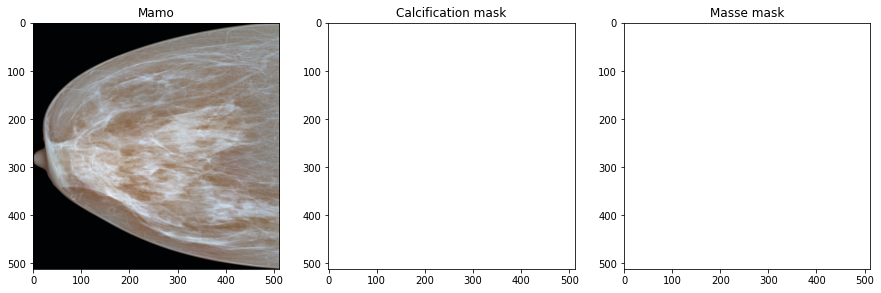

In [ ]:
# r=random.choice(glob.glob('GenDataset/'+'Images/*')).split("/")[-1]
r=random.choice(glob.glob('Train_Set/'+'Images/*')).split("/")[-1]

fig = plt.figure(figsize=(15, 15))

fig.add_subplot(131)
# fig.add_subplot(121)
plt.title("Mamo")
plt.imshow(dicom.dcmread('Train_Set/'+'Images/'+r).pixel_array)

dc_test_mask_cal=dicom.dcmread('Train_Set/'+'Masks_cal/'+r).pixel_array
fig.add_subplot(132)
# fig.add_subplot(122)
plt.title("Calcification mask")
plt.imshow(dc_test_mask_cal, cmap="binary")

dc_test_mask_masse=dicom.dcmread('Train_Set/'+'Masks_masses/'+r).pixel_array

fig.add_subplot(133)
plt.title("Masse mask")
plt.imshow(dc_test_mask_masse, cmap="binary")
print("nb calc", len(np.unique(dc_test_mask_cal))-1,)#"nb masses", len(np.unique(dc_test_mask_masse))-1)
plt.show()

# **Truth_Data_generators**

**Preprocess true boxes to training input format**
    Parameters
    ----------
    true_boxes: array, shape=(m, T, 5)
        Absolute x_min, y_min, x_max, y_max, class_id relative to input_shape.
    input_shape: array-like, hw, multiples of 32
    anchors: array, shape=(N, 2), wh
    num_classes: integer
    Returns
    -------
    y_true: list of array, shape like yolo_outputs, xywh are reletive value
    

In [ ]:
def preprocess_true_boxes(true_boxes, input_shape, anchors, num_classes):
   
    assert (true_boxes[..., 4]<num_classes).all(), 'class id must be less than num_classes'
    num_layers = len(anchors)//3 # default setting
    anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] if num_layers==3 else [[3,4,5], [1,2,3]]

    true_boxes = np.array(true_boxes, dtype='float32')
    input_shape = np.array(input_shape, dtype='int32')
    boxes_xy = (true_boxes[..., 0:2] + true_boxes[..., 2:4]) // 2
    boxes_wh = true_boxes[..., 2:4] - true_boxes[..., 0:2]
    true_boxes[..., 0:2] = boxes_xy/input_shape[::-1]
    true_boxes[..., 2:4] = boxes_wh/input_shape[::-1]


    m = true_boxes.shape[0]
    grid_shapes = [input_shape//{0:32, 1:16, 2:8}[l] for l in range(num_layers)]
    y_true = [np.zeros((m,grid_shapes[l][0],grid_shapes[l][1],len(anchor_mask[l]),5+num_classes),
        dtype='float32') for l in range(num_layers)]

    # Expand dim to apply broadcasting.
    anchors = np.expand_dims(anchors, 0)
    anchor_maxes = anchors / 2.
    anchor_mins = -anchor_maxes
    valid_mask = boxes_wh[..., 0]>0

    for b in range(m):
        # Discard zero rows.
        wh = boxes_wh[b, valid_mask[b]]
        if len(wh)==0: continue
        # Expand dim to apply broadcasting.
        wh = np.expand_dims(wh, -2)
        box_maxes = wh / 2.
        box_mins = -box_maxes

        intersect_mins = np.maximum(box_mins, anchor_mins)
        intersect_maxes = np.minimum(box_maxes, anchor_maxes)
        intersect_wh = np.maximum(intersect_maxes - intersect_mins, 0.)
        intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]
        box_area = wh[..., 0] * wh[..., 1]
        anchor_area = anchors[..., 0] * anchors[..., 1]
        iou = intersect_area / (box_area + anchor_area - intersect_area)

        # Find best anchor for each true box
        best_anchor = np.argmax(iou, axis=-1)

        for t, n in enumerate(best_anchor):
            for l in range(num_layers):
                if n in anchor_mask[l]:
                    i = np.floor(true_boxes[b,t,0]*grid_shapes[l][1]).astype('int32')
                    j = np.floor(true_boxes[b,t,1]*grid_shapes[l][0]).astype('int32')
                    k = anchor_mask[l].index(n)
                    c = true_boxes[b,t, 4].astype('int32')
                    y_true[l][b, j, i, k, 0:4] = true_boxes[b,t, 0:4]
                    y_true[l][b, j, i, k, 4] = 1
                    y_true[l][b, j, i, k, 5+c] = 1

    return y_true

In [ ]:
from itertools import count
def data_generator(ens,batch_size, input_shape, anchors, num_classes,size,DatasetPath):
    
    # if(ens==1):
    #   n = 240
    #   Gen=train_generator
    # elif(ens==2): 
    #   n=68
    #   Gen=val_generator
    n=len(ens)
    i = 0
    
    while True:
        image_data = []
        list_box_data = []
        # image,mask=next(Gen)
        
        for b in range(batch_size):
            box = []
            image= dicom.dcmread(DatasetPath+'Images/'+ens[i]).pixel_array/255
            #---------------------
            mask_cal= dicom.dcmread(DatasetPath+'Masks_cal/'+ens[i]).pixel_array
            mask_masse=dicom.dcmread(DatasetPath+'Masks_masses/'+ens[i]).pixel_array

            if size != 1024:
              image= cv2.resize(image, (size, size), interpolation = cv2.INTER_AREA)
              mask_cal= cv2.resize(mask_cal, (size, size), interpolation = cv2.INTER_NEAREST)
              mask_masse=cv2.resize(mask_masse, (size, size), interpolation = cv2.INTER_NEAREST)

            image_data.append(image)
        
            box_cal=mask_to_yolo(mask_cal,0)
            [box.append(bx) for bx in box_cal]
          
            box_masse=mask_to_yolo(mask_masse,1)
            [box.append(bx) for bx in box_masse]
         
            box_data = np.zeros((500,5))
            box=np.array(box)
            
            if (len(box)>0):
              box_data[:len(box)] =box

        
            list_box_data.append(box_data)
            i = (i+1) % n
        
        #-------------------
        list_box_data=np.array(list_box_data)
       
        image_data=np.array(image_data)

     
        y_true = preprocess_true_boxes(list_box_data, input_shape, anchors, num_classes)
        
        yield [image_data, *y_true], np.zeros(batch_size)

In [ ]:
def rand(a=0, b=1):
    return np.random.rand()*(b-a) + a

**extarct classes from txt file**

In [ ]:
def get_classes(classes_path):
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

**loads the anchors from a file**

In [ ]:
def get_anchors(anchors_path):
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)

# **Training process**

In [ ]:
#@title plot_training_statistics{form-width: "1%"}
def plot_training_statistics(history, path):
    epochs = [i for i in range(1, len(history['loss'])+1)]

    plt.figure(figsize=(20,6))
    keys = history.keys()
    keys = [key for key in keys if not "lr" in key and not "val_" in key]
    
    for idx, key in enumerate(keys):
        plt.subplot(1, len(keys), idx+1)
        plt.plot(epochs, history[key], label="training_"+key)
        plt.plot(epochs, history['val_'+key], label="validation_"+key)
        plt.legend(loc='best')
        plt.title(key)
        plt.xlabel('epoch')

    # plt.subplot(1, len(keys)+1,idx+1)
    # plt.title('learning_rate')
    # plt.xlabel('epoch')
    # plt.plot(epochs, history['lr'], label="learning_rate")

    # plt.savefig(f'{path}ploted_stats.png')
    plt.show()
    plt.close('all')

In [ ]:
#@title Anchors{form-width: "1%"}

#0,1,  0,0,  1,0,  2,1,  4,2,  6,3,  11,6,  21,11,  67,38
#anchors of masses and calcification
# anchors=np.array([[  0.62 ,   0.51 ],
#        [  2.24 ,   1.2  ],
#        [  5.09 ,   2.63 ],
#        [  9.91 ,   4.99 ],
#        [ 23.215,  11.155],
#        [ 56.485,  26.665],
#        [106.62 ,  53.665],
#        [180.46 ,  96.915],
#        [287.555, 181.29 ]])

# anchors = get_anchors(anchors_path)
# ANCHORS OF  just Callcifications
# anchors= np.array([[ 1.,   1.],
#  [ 1.51923077,2.38461538],
#  [ 2.45454545 , 1.        ],
#  [ 2.74509804 , 5.17647059],
#  [ 4.42857143 ,10.95238095],
#  [ 4.87301587 , 2.33333333],
#  [ 5.         , 1.        ],
#  [10.68421053 , 4.47368421],
#  [30.65       ,11.7       ]])

anchors=[[300,66,333,279,372,362],[163,272,242,130,299,191],[51,43,78, 218,116,84 ]]
300,66, 333,279, 372,362, 163,272, 242,130, 299,191, 51,43, 78, 218, 116,84
anchors= [[0.01659321,0.00996796],
[0.02322134,0.01339871],
 [0.04895603,0.02613155],
 [0.09038873,0.04803848],
  [0.15177747,0.07992665],
  [0.22864079,0.12244233],
  [0.37213292,0.19061959],
   [0.69372979,0.35726062],
  [2.0586748,1.06487927]]
 anchors= 10,13,  16,30,  33,23,  30,61,  62,45,  59,119,  116,90,  156,198,  373,326
 12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459,


IndentationError: ignored

##Train

In [ ]:
# annotation_path ='/content/Augmented_Dataset/Yolo_data.txt'
classesFile = '/content/drive/MyDrive/Colab Notebooks/Classes.txt'
class_names = get_classes(classesFile)
num_classes = len(class_names)
# anchors_path = '/content/drive/MyDrive/Colab Notebooks/yolo_anchors.txt'
anchors = np.array([[116,90],  [156,198],  [373,326],  [30,61], [62,45],  [59,119], [10,13],  [16,30],  [33,23]])
num_anchors = len(anchors)
print(num_anchors)
input_shape = (512,512)
print("____ok__ i have :{} Classes_&_the input_sahpe is{}:".format(num_classes,input_shape))

9
____ok__ i have :2 Classes_&_the input_sahpe is(512, 512):


**Creat the model**

In [ ]:
from keras.regularizers import l2
model = create_model(input_shape, anchors ,num_classes,backboon='Darknet' ,load_pretrained=False)

yolo based Darknet
Create YOLOv3 model based on Darknet with 9 anchors and 2 classes.


**Show the Summary**

In [ ]:
model.summary()



*   **Creating checkpoit model**to save loss and acc after each epoch
*   **EarlyStopping To stop trining when we got the best rslts during the training**
the goal of this is to to mim the risque of** ouver fiting**  
***reduce_lr to** reduce the leraning rat The parameter **learning rate** controls how aggressively we should learn based on the current batch of data. Typically this is a number between 0.01 and 0.0001.









In [ ]:
!rm -r '/content/newDatalog'
log_dir = '/content/newDatalog'
logging = TensorBoard(log_dir=log_dir, write_graph = True,write_images= True,) #enable visualizations for TensorBoard
reduce_lr = ReduceLROnPlateau(monitor='loss' , factor=0.1, patience=2, 
              verbose=1, mode= 'min', min_delta  = 0.01 ,min_lr = 0) #to reducing the learning rate verbose 1 to  update messages.

# checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5', monitor='val_loss', save_weights_only=True, save_best_only=True, save_freq='epoch')   #period=3,
# early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

rm: cannot remove '/content/newDatalog': No such file or directory


In [ ]:
random.seed(30)
ens=[p.split("/")[-1] for p in glob.glob('Train_Set/Images/*')]
random.shuffle(ens)
len(ens), ens[0]

(2772, '96.dcm')

**Compile The Model**

In [ ]:
from tensorflow.keras.optimizers import *
from tensorflow.keras.metrics import *
import copy
# continuous_hist=copy.deepcopy(history.history)

RMSprop=RMSprop(learning_rate=0.001,rho=0.9,momentum=0.0,epsilon=1e-07,centered=False,name="RMSprop")
ada=Adadelta(learning_rate=0.001, rho=0.95, epsilon=1e-07, name="Adadelta")
sgd = SGD(learning_rate=0.001, decay=1e-4, momentum=0.8, nesterov=True) #0.1
opt=Adam(learning_rate=1e-4)

model.compile(optimizer=opt, loss={'yolo_loss': lambda y_true, y_pred: y_pred},)#metrics=[Recall(),Precision(),Accuracy()]) #,Recall(),Precision()
# from sklearn.metrics import roc_curve, auc

**Fit The Model**

In [ ]:
batch_size=16
history=model.fit(data_generator(ens[len(ens)//10:],batch_size, input_shape, anchors, num_classes, size, 'Train_Set/'),      
    validation_data= data_generator(ens[:len(ens)//10], batch_size, input_shape, anchors, num_classes, size, 'Train_Set/'),
    steps_per_epoch=len(ens)//10*9//batch_size,
    validation_steps=len(ens)//10//batch_size,
    epochs=5 ,
    shuffle=False, 
    callbacks=[logging,reduce_lr]  
)

Epoch 1/5
 29/155 [====>.........................] - ETA: 5:18 - loss: 918.1736 - location_loss: 0.2593 - confidence_loss: 906.2651 - class_loss: 0.0076

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


155/155 [==============================] - 477s 3s/step - loss: 203.2099 - location_loss: 0.2451 - confidence_loss: 191.3204 - class_loss: 0.0054 - val_loss: 213.0188 - val_location_loss: 0.2005 - val_confidence_loss: 201.1842 - val_class_loss: 0.0032 - lr: 1.0000e-04
Epoch 2/5
155/155 [==============================] - 459s 3s/step - loss: 20.6610 - location_loss: 0.2420 - confidence_loss: 8.7939 - class_loss: 0.0043 - val_loss: 30.9778 - val_location_loss: 0.2070 - val_confidence_loss: 19.1579 - val_class_loss: 0.0029 - lr: 1.0000e-04
Epoch 3/5
155/155 [==============================] - 494s 3s/step - loss: 16.9788 - location_loss: 0.2411 - confidence_loss: 5.1352 - class_loss: 0.0038 - val_loss: 18.2615 - val_location_loss: 0.1994 - val_confidence_loss: 6.4724 - val_class_loss: 0.0030 - lr: 1.0000e-04
Epoch 4/5
155/155 [==============================] - 495s 3s/step - loss: 15.3756 - location_loss: 0.2421 - confidence_loss: 3.5558 - class_loss: 0.0036 - val_loss: 15.9206 - val_locat

rm: cannot remove '/content/newDatalog/plots_models/': No such file or directory
Error: empty directory, model version: 0


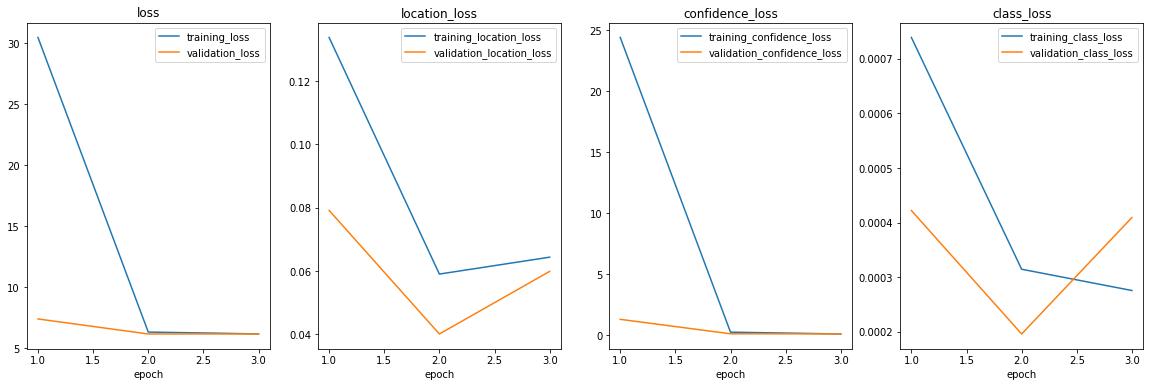

In [ ]:
path= '/content/newDatalog/plots_models/'
!rm -r {path}
!mkdir {path}
try:
  v=max([int(p.split('/')[-1]) for p in glob(f'{path}*')])+1
  print("model version:", v)
except:
  v=0
  print("Error: empty directory, model version:", v)
!mkdir {path}{v}
plot_training_statistics(history.history, f'{path}{v}/')

In [ ]:
from tensorflow.keras.optimizers import *
from tensorflow.keras.metrics import *
import copy
continuous_hist=copy.deepcopy(history.history)


for i in range(len(model.layers)):
            model.layers[i].trainable = True
print('Unfreeze all of the layers.')


RMSprop=RMSprop(learning_rate=0.0015,rho=0.9,momentum=0.97,epsilon=1e-08,decay=0.0,centered=False,name="RMSprop")
ada=Adadelta(learning_rate=0.0001, rho=0.95 , decay=0.0, epsilon=1e-08, name="Adadelta")
sgd = SGD(learning_rate=0.0001, decay=1e-4, momentum=0.97, nesterov=True) #learning_rate=0.01  decay=1e-4
opt=Adam(learning_rate=0.0001, )#beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #0.0001

model.compile(optimizer=opt, loss={'yolo_loss': lambda y_true, y_pred: y_pred})#,metrics=['acc'])#metrics=[Recall()]) #Accuracy(),Recall(),Precision()

Unfreeze all of the layers.


In [ ]:
import copy
continuous_hist=copy.deepcopy(history.history)

batch_size =16
history=model.fit(data_generator(ens[len(ens)//10:],batch_size, input_shape, anchors, num_classes, size, 'Train_Set/'),
                validation_data= data_generator(ens[:len(ens)//10], batch_size, input_shape, anchors, num_classes, size, 'Train_Set/'),
                steps_per_epoch=len(ens)//10*9//batch_size,
                validation_steps=len(ens)//10//batch_size,
                initial_epoch=5,
                epochs=100,    
                shuffle=False,  
                callbacks=[ logging,reduce_lr])

Epoch 6/100
 20/155 [==>...........................] - ETA: 5:31 - loss: 17.5210 - location_loss: 0.3368 - confidence_loss: 5.6996 - class_loss: 0.0052

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


155/155 [==============================] - 448s 3s/step - loss: 13.2887 - location_loss: 0.2460 - confidence_loss: 1.7184 - class_loss: 0.0037 - val_loss: nan - val_location_loss: nan - val_confidence_loss: 150.5244 - val_class_loss: 0.3325 - lr: 1.0000e-04
Epoch 7/100
155/155 [==============================] - 464s 3s/step - loss: 11.4517 - location_loss: 0.2448 - confidence_loss: 0.3998 - class_loss: 0.0033 - val_loss: 11.1275 - val_location_loss: 0.2613 - val_confidence_loss: 0.3565 - val_class_loss: 0.0054 - lr: 1.0000e-04
Epoch 8/100
155/155 [==============================] - 434s 3s/step - loss: 10.6901 - location_loss: 0.2453 - confidence_loss: 0.2500 - class_loss: 0.0031 - val_loss: 10.3822 - val_location_loss: 0.2635 - val_confidence_loss: 0.2402 - val_class_loss: 0.0038 - lr: 1.0000e-04
Epoch 9/100
155/155 [==============================] - 421s 3s/step - loss: 9.9962 - location_loss: 0.2463 - confidence_loss: 0.1856 - class_loss: 0.0031 - val_loss: 9.7070 - val_location_loss

In [ ]:
for key in continuous_hist.keys():
  for element in history.history[key]:
    continuous_hist[key].append(element)

Error: empty directory, model version: 0


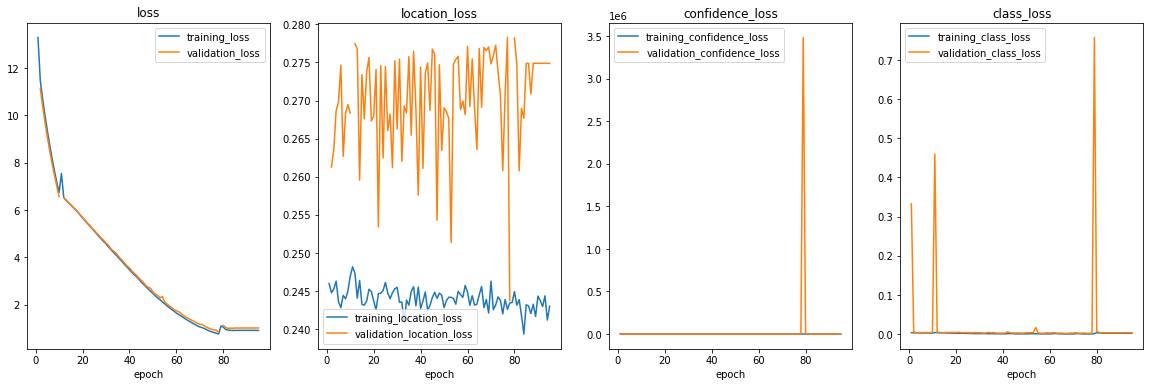

In [ ]:
path= '/content/newDatalog/plots_models/'
!rm -r {path}
!mkdir {path}
try:
  v=max([int(p.split('/')[-1]) for p in glob(f'{path}*')])+1
  print("model version:", v)
except:
  v=0
  print("Error: empty directory, model version:", v)
!mkdir {path}{v}

plot_training_statistics(history.history, f'{path}{v}/')

Error: empty directory, model version: 0


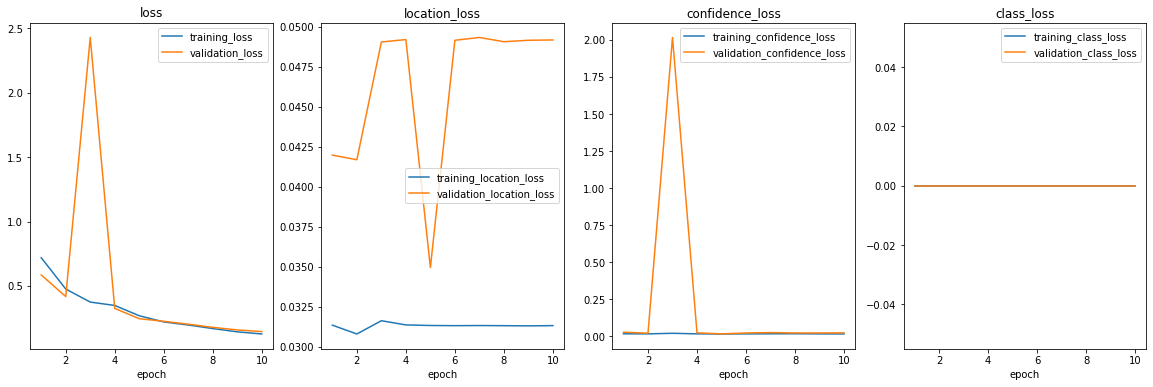

In [ ]:
path= '/content/newDatalog/plots_models/'
!rm -r {path}
!mkdir {path}
try:
  v=max([int(p.split('/')[-1]) for p in glob(f'{path}*')])+1
  print("model version:", v)
except:
  v=0
  print("Error: empty directory, model version:", v)
!mkdir {path}{v}

plot_training_statistics(history.history, f'{path}{v}/')

In [ ]:
model.save('/content/drive/My Drive/Detection_models/masse_cal_v7.h5')
!zip -r '/content/drive/MyDrive/Detection_models/TensorBoard/masse_cal_v7.zip' '/content/newDatalog'

  adding: content/newDatalog/ (stored 0%)
  adding: content/newDatalog/plots_models/ (stored 0%)
  adding: content/newDatalog/plots_models/0/ (stored 0%)
  adding: content/newDatalog/validation/ (stored 0%)
  adding: content/newDatalog/validation/events.out.tfevents.1659343256.4221cd04a75b.528.1.v2 (deflated 72%)
  adding: content/newDatalog/validation/events.out.tfevents.1659345911.4221cd04a75b.528.3.v2 (deflated 80%)
  adding: content/newDatalog/train/ (stored 0%)
  adding: content/newDatalog/train/events.out.tfevents.1659342908.4221cd04a75b.528.0.v2 (deflated 93%)
  adding: content/newDatalog/train/events.out.tfevents.1659345572.4221cd04a75b.528.2.v2 (deflated 93%)


**serialize model to JSON**

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

In [ ]:
# Precision = (True Positive)/(True Positive + False Positive)
# Recall = (True Positive)/(True Positive + False Negative)
# F1 score = (Precision × Recall)/[(Precision + Recall)/2]

In [ ]:
# https://github.com/Adamdad/Object-Detection-Metrics/blob/master/pascalvoc.py EVALUATION
#https://github.com/ashish-roopan/mAP  

##**Fine-tuning**

**Unfreeze and continue training** & **Compile** the model with my **custom loss function**

> Stochastic Gradient Descent SGD

1.  Frequent updates of model parameter
2.  Requires less Memory.
Allows the use of large data sets as it has to update only one example at a time.


**momentum** is used to penalize large weight changes between iterations.

 penalize large value for weights with  **decay** controls this penalty term. 

In [ ]:
from tensorflow.keras.optimizers import *
for i in range(len(model.layers)):
            model.layers[i].trainable = True
print('Unfreeze all of the layers.')

RMSprop=RMSprop(learning_rate=0.0001,rho=0.9,momentum=0.0,epsilon=1e-07,centered=False,name="RMSprop")
ada=Adadelta(learning_rate=0.001, rho=0.95, epsilon=1e-07, name="Adadelta")
sgd = SGD(learning_rate=0.0001, decay=1e-4, momentum=0.97, nesterov=True) #learning_rate=0.01  decay=1e-4
opt=Adam(learning_rate=1.0000e-04) #0.0001

model.compile(optimizer=RMSprop, loss={'yolo_loss': lambda y_true, y_pred: y_pred},) 

Unfreeze all of the layers.


**Begin the fine-tuning**


> batch size les then first trinig because that more GPU memory is required after unfreezing the body



In [ ]:
batch_size =16
history=model.fit(data_generator(ens[len(ens)//10:],batch_size, input_shape, anchors, num_classes, size, 'GenDataset/'),
                validation_data= data_generator(ens[:len(ens)//10], batch_size, input_shape, anchors, num_classes, size, 'GenDataset/'),
                steps_per_epoch=len(ens)//10*9//batch_size,
                validation_steps=len(ens)//10//batch_size,
                initial_epoch=5,
                epochs=10,
                shuffle=False,  
                callbacks=[ logging,reduce_lr]) 

Epoch 6/10
155/155 [==============================] - 796s 5s/step - loss: 0.3989 - location_loss: 0.0165 - confidence_loss: 0.0687 - class_loss: 0.0023 - val_loss: 0.3009 - val_location_loss: 0.0077 - val_confidence_loss: 0.0044 - val_class_loss: 0.0010 - lr: 1.0000e-04
Epoch 7/10
155/155 [==============================] - 750s 5s/step - loss: 0.3411 - location_loss: 0.0166 - confidence_loss: 0.0704 - class_loss: 0.0012 - val_loss: 0.2473 - val_location_loss: 0.0077 - val_confidence_loss: 0.0028 - val_class_loss: 7.4111e-04 - lr: 1.0000e-04
Epoch 8/10
155/155 [==============================] - 765s 5s/step - loss: 0.2385 - location_loss: 0.0162 - confidence_loss: 0.0054 - class_loss: 8.7051e-04 - val_loss: 0.2064 - val_location_loss: 0.0077 - val_confidence_loss: 0.0027 - val_class_loss: 5.5117e-04 - lr: 1.0000e-04
Epoch 9/10
155/155 [==============================] - 753s 5s/step - loss: 0.7836 - location_loss: 0.0159 - confidence_loss: 0.5746 - class_loss: 6.9033e-04 - val_loss: 0.1

rm: cannot remove '/content/newDatalog/plots_models/': No such file or directory
Error: empty directory, model version: 0


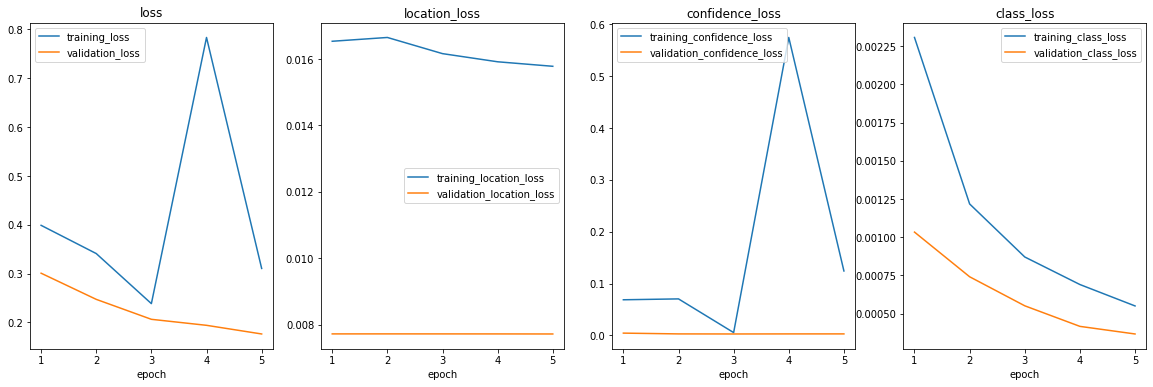

In [ ]:
path= '/content/newDatalog/plots_models/'
!rm -r {path}
!mkdir {path}
try:
  v=max([int(p.split('/')[-1]) for p in glob(f'{path}*')])+1
  print("model version:", v)
except:
  v=0
  print("Error: empty directory, model version:", v)
!mkdir {path}{v}

plot_training_statistics(history.history, f'{path}{v}/')

In [ ]:
model.save('/content/drive/My Drive/Detection_models/best_yolov3.h5')

**Plot loss resalts**
after fin_tuning of My model

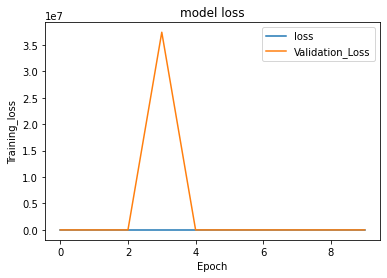

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model loss")
plt.ylabel("Training_loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation_Loss"])
plt.show()

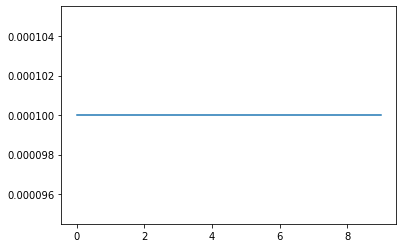

In [ ]:
plt.plot(history.history['lr'])

##**Tensorboard vusialisation**

In [ ]:
!unzip '/content/drive/MyDrive/Detection_models/TensorBoard/Best_log.zip' -r '01'
!unzip '/content/drive/MyDrive/Detection_models/TensorBoard/best_log2.zip' -r '02'
!unzip '/content/drive/MyDrive/Detection_models/TensorBoard/newDatalogv1.zip' -r '03'
!unzip '/content/drive/MyDrive/Detection_models/TensorBoard/newDatalogv2.zip' -r '04'

In [ ]:
!rm -r '/content/newDatalog/plots_models'

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir='/content/newDatalog/train/'

#Evaluation

In [ ]:
# measure mAP of trained custom model
TEST_SCORE_THRESHOLD=
TEST_IOU_THRESHOLD=
save_directory=
try:
  mAP_model.load_weights(save_directory) # use keras weights
  get_mAP(mAP_model, testset, score_threshold=TEST_SCORE_THRESHOLD, iou_threshold=TEST_IOU_THRESHOLD)
except UnboundLocalError:
  print("You don't have saved model weights to measure mAP,")

#Predictions

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

## **Decode Yolo output**

In [ ]:
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        
        self.objness = objness
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        
        return self.label
    
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
            
        return self.score

    def print_Krimo(self):
      print("Xmin=",self.xmin,
        "ymin=",self.ymin,
        "xmax=",self.xmax,
        "ymax=",self.ymax,
        "Obj=",self.objness ,
        "Classes=",self.classes         
        )

In [ ]:
def preprocess_input(image, net_h, net_w):
    new_h, new_w, _ = image.shape

    # determine the new size of the image
    if (float(net_w)/new_w) < (float(net_h)/new_h):
        new_h = (new_h * net_w)//new_w
        new_w = net_w
    else:
        new_w = (new_w * net_h)//new_h
        new_h = net_h

    # resize the image to the new size
    resized = cv2.resize(image[:,:,::-1]/255., (new_w, new_h))

    # embed the image into the standard letter box
    new_image = np.ones((net_h, net_w, 3)) * 0.5
    new_image[(net_h-new_h)//2:(net_h+new_h)//2, (net_w-new_w)//2:(net_w+new_w)//2, :] = resized
    new_image = np.expand_dims(new_image, 0)

    return new_image

In [ ]:
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

In [ ]:
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5

    boxes = []

    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh

    print(netout[..., 5:] > obj_thresh)
    
    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w
        
        for b in range(nb_box):
            # 4th element is objectness score
            # print(netout[int(row)][int(col)][b][4])
            objectness = netout[int(row)][int(col)][b][4]
            #objectness = netout[..., :4]
            # print(objectness.all())
            if(objectness.all() <= obj_thresh): continue 
            
            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[int(row)][int(col)][b][:4]

            x = (col + x) / grid_w # center position, unit: image width
            y = (row + y) / grid_h # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height  
              
            # last elements are class probabilities
            classes = netout[int(row)][col][b][5:]
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            # print(box)
            #box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, None, classes)

            boxes.append(box) 
            
    return boxes

 back into the shape of the original image

In [ ]:
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    if (float(net_w)/image_w) < (float(net_h)/image_h):
        new_w = net_w
        new_h = (image_h*net_w)/image_w
    else:
        new_h = net_w
        new_w = (image_w*net_h)/image_h
        
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

Bounding boxes will be filtered based on the overlap defined by IoU and then applying the non-max suppression

In [ ]:
def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect = intersect_w * intersect_h
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union

In [ ]:
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2,x4) - x3

In [ ]:
def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        print("len box = 0")
        return
        
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        # print("sorted_indices \n",sorted_indices)
        # print("len sorted_indices=",len(sorted_indices))
        for i in trange(len(sorted_indices)):
            
            index_i = sorted_indices[i]

            if boxes[index_i].classes[c] == 0 : continue

            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]

                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

**preprocess the image**

In [ ]:
def draw_boxes(image, boxes, labels, obj_thresh):
    for box in boxes:
        label_str = ''
        label = -1
        
        for i in range(1):  #len(labels)
            # print(box.classes[i])
            if box.classes[i] >=obj_thresh:
                label_str += labels[i]
                label = i
                print("DKHAL label=",label)
                # print(labels[i] + ': ' + str(box.classes[i]*100) + '%')
        if label >= 0:
            print("Draw")
            cv2.rectangle(image, (box.xmin,box.ymin), (box.xmax,box.ymax), (0,255,0), 3)
            # cv2.putText(image, 
            #             label_str + ' ' + str(box.get_score()), 
            #             (box.xmin, box.ymin - 13), 
            #             cv2.FONT_HERSHEY_SIMPLEX, 
            #             1e-3 * image.shape[0], 
            #             (0,255,0), 2)
           
    return image      

##**Load model and predict**

In [ ]:
%%capture
!unzip '/content/drive/MyDrive/INBreast_Dataset/Dicom_Test_data.zip'

In [ ]:
!rm -r '/content/content'

In [ ]:
num_anchors=9
num_classes=2
model_path='/content/drive/MyDrive/Detection_models/masse_cal_v5.h5'
# model = load_model(model_path, compile=False)
try:
            model = load_model(model_path,compile=False)
except:
            model=yolo_body(Input(shape=(None,None,3)), num_anchors//3, num_classes)
            model.load_weights(model_path) 

nb calc 5
nb masses 0


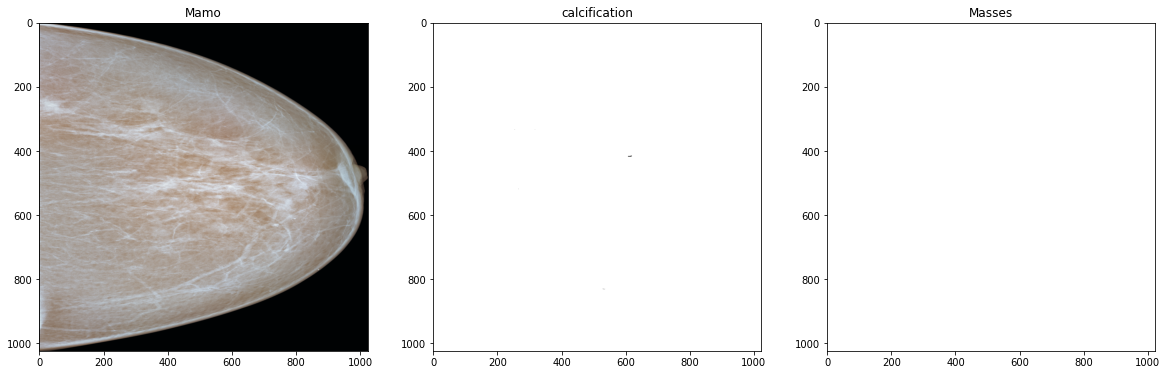

In [ ]:
r=random.choice(glob.glob('Test_Set/'+'Images/*')).split("/")[-1]
fig = plt.figure(figsize=(20, 20))
fig.add_subplot(131)
plt.title("Mamo")
plt.imshow(dicom.dcmread('Test_Set/'+'Images/'+r).pixel_array)

dc_mask_cal=dicom.dcmread('Test_Set/'+'Masks_cal/'+r).pixel_array
print("nb calc",len(np.unique(dc_mask_cal))-1)
fig.add_subplot(132)
plt.title("calcification")
plt.imshow(dc_mask_cal, cmap="binary")


dc_mask_masse=dicom.dcmread('Test_Set/'+'Masks_masses/'+r).pixel_array
print("nb masses", len(np.unique(dc_mask_masse))-1)

fig.add_subplot(133)
plt.title("Masses")
plt.imshow(dc_mask_masse, cmap="binary")
plt.show()

# set some parameters
# anchors = [[116,90,  156,198,  373,326],  [30,61, 62,45,  59,119], [10,13,  16,30,  33,23]]
#anchors =[[1,1,  1.51923077,2.38461538,  2.45454545,1],  [2.74509804,5.17647059,   4.42857143,10.95238095,  4.87301587 , 2.33333333],  [5,1,  10.68421053,4.47368421,  30.65,11.7]]
anchors =[[0.62,0.51,  2.24,1.2,  5.09,2.63],  [9.91,4.99,  23.215,11.155,  56.485,26.665],  [106.62,53.665,  180.46,96.915,  287.555,181.29]]
net_h, net_w = 512,512

image=dicom.dcmread('Test_Set/'+'Images/'+r).pixel_array
new_image = preprocess_input(image, net_h, net_w)

predection=model.predict(new_image)

# image_resized = cv2.resize(image, (512, 512), interpolation=cv2.INTER_CUBIC)
# predection=model.predict(np.expand_dims(image_resized,axis=0))

yolo predict bbx at three defrentte scale

In [ ]:
print(len(predection))
# print(predection[1])

3


In [ ]:
obj_thresh= 0.3
Abdou = list()
cpt=0
for i in range(len(predection)):
  # decode the output of the network
  Abdou += decode_netout(predection[i][0], anchors[i], obj_thresh, net_h, net_w)
  cpt+=1

print('len: Abdou =',len(Abdou),'cpt=',cpt) 

[[[[ True  True]
   [ True  True]
   [ True  True]]

  [[ True  True]
   [ True  True]
   [ True  True]]

  [[ True  True]
   [ True  True]
   [ True  True]]

  ...

  [[ True  True]
   [ True  True]
   [ True  True]]

  [[ True  True]
   [ True  True]
   [ True  True]]

  [[ True  True]
   [ True  True]
   [ True  True]]]


 [[[ True  True]
   [ True  True]
   [ True  True]]

  [[ True  True]
   [ True  True]
   [ True  True]]

  [[ True  True]
   [ True  True]
   [ True  True]]

  ...

  [[ True  True]
   [ True  True]
   [ True  True]]

  [[ True  True]
   [ True  True]
   [ True  True]]

  [[ True  True]
   [ True  True]
   [ True  True]]]


 [[[ True  True]
   [ True  True]
   [ True  True]]

  [[ True  True]
   [ True  True]
   [ True  True]]

  [[ True  True]
   [ True  True]
   [ True  True]]

  ...

  [[ True  True]
   [ True  True]
   [ True  True]]

  [[ True  True]
   [ True  True]
   [ True  True]]

  [[ True  True]
   [ True  True]
   [ True  True]]]


 ...


 [[[ True  T

In [ ]:
# correct the sizes of the bounding boxes
image_h, image_w, _ = image.shape

print("akeaea:",Abdou[1000].get_label(),Abdou[1000].get_score())
Abdou[0].print_Krimo()
correct_yolo_boxes(Abdou, image_h, image_w, net_h, net_w)
print("Corrected len =",len(Abdou))
print("------Corrected---------:",Abdou[1000].get_label(),Abdou[1000].get_score())
Abdou[0].print_Krimo()

# suppress non-maximal boxes
nms_thresh =0.7
do_nms(Abdou, nms_thresh)
print("*****:",Abdou[1000].get_label(),Abdou[1000].get_score())
Abdou[0].print_Krimo()
print("nms len =",len(Abdou))

akeaea: 0 0.31206396
Xmin= 0.040068137347698214 ymin= 0.040175559222698214 xmax= 0.04127907484769821 ymax= 0.04117165297269821 Obj= 0.62265086 Classes= [0.31132543 0.31132543]
Corrected len = 16128
------Corrected---------: 0 0.31206396
Xmin= 41 ymin= 41 xmax= 42 ymax= 42 Obj= 0.62265086 Classes= [0.31132543 0.31132543]


  0%|          | 0/16128 [00:00<?, ?it/s]

  0%|          | 0/16128 [00:00<?, ?it/s]

*****: 0 0.31206396
Xmin= 41 ymin= 41 xmax= 42 ymax= 42 Obj= 0.62265086 Classes= [0.31132543 0.31132543]
nms len = 16128


In [ ]:
Abdou[600].print_Krimo()

Xmin= 553 ymin= 841 xmax= 554 ymax= 842 Obj= 0.62253904 Classes= [0.31126952 0.31126952]


In [ ]:
img=image.copy()

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
DKHAL label= 0
Draw
DKHAL label= 0
Draw
DKHAL label= 0
Draw
DKHAL label= 0
Draw
DKHAL label= 0
Draw
DKHAL label= 0
Draw
DKHAL label= 0
Draw
DKHAL label= 0
Draw
DKHAL label= 0
Draw
DKHAL label= 0
Draw
DKHAL label= 0
Draw
DKHAL label= 0
Draw
DKHAL label= 0
Draw
DKHAL label= 0
Draw
DKHAL label= 0
Draw
DKHAL label= 0
Draw
DKHAL label= 0
Draw
DKHAL label= 0
Draw
DKHAL label= 0
Draw
DKHAL label= 0
Draw
DKHAL label= 0
Draw
DKHAL label= 0
Draw
DKHAL label= 0
Draw
DKHAL label= 0
Draw
DKHAL label= 0
Draw
DKHAL label= 0
Draw
DKHAL label= 0
Draw
DKHAL label= 0
Draw
DKHAL label= 0
Draw
DKHAL label= 0
Draw
DKHAL label= 0
Draw
DKHAL label= 0
Draw
DKHAL label= 0
Draw
DKHAL label= 0
Draw
DKHAL label= 0
Draw
DKHAL label= 0
Draw
DKHAL label= 0
Draw
DKHAL label= 0
Draw
DKHAL label= 0
Draw
DKHAL label= 0
Draw
DKHAL label= 0
Draw
DKHAL label= 0
Draw
DKHAL label= 0
Draw
DKHAL label= 0
Draw
DKHAL label= 0
Draw
DKHAL label= 0
Draw
DK

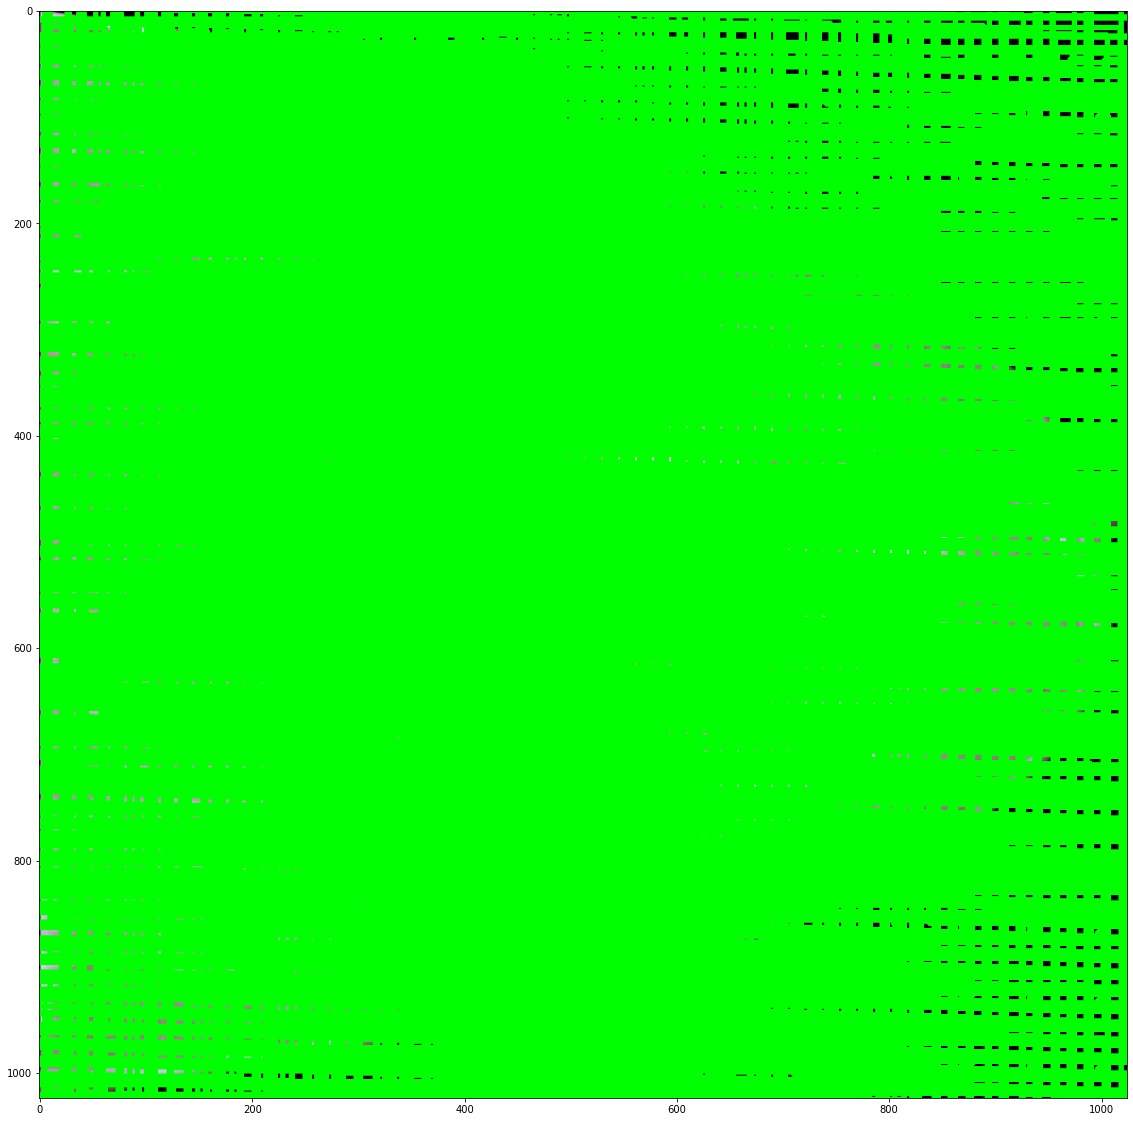

In [ ]:
# define the labels
labels = ["Calcification","Masse"]
# draw bounding boxes on the image using labels
obj_thresh=0.3
ig=draw_boxes(img, Abdou, labels, obj_thresh) 
plt.figure(figsize=(20,20))
plt.imshow(ig)

In [ ]:
# # get the details of the detected objects
# class_threshold = 0.1
# v_boxes, v_labels, v_scores = get_boxes(Abdou, labels, class_threshold)

# print(len(v_scores),"-----")
# for i in range(len(v_boxes)):
# 	print(v_labels[i], v_scores[i],v_boxes[i].xmin,v_boxes[i].ymin,v_boxes[i].xmax,v_boxes[i].ymax)
# # draw what we found
# draw_boxes(image, v_boxes, v_labels, v_scores)
# plt.show()

In [ ]:
def get_boxes(boxes, labels, thresh):
    print('---get_boxes---len:boxes',len(boxes))
    v_boxes, v_labels, v_scores = list(), list(), list()
    # enumerate all boxes
    for box in boxes:
        # enumerate all possible labels
        for i in range(len(labels)):
            # check if the threshold for this label is high enough
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
                # don't break, many labels may trigger for one box
    return v_boxes, v_labels, v_scores

In [ ]:
# write the image with bounding boxes to file

# cv2.imwrite(image_path[:-4] + '_detected' + image_path[-4:], (image).astype('uint8')) 

#**trush**

## **Decode Yolo output**

In [ ]:
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        
        self.objness = objness
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        
        return self.label
    
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
            
        return self.score

**extarct classes from txt file**

In [ ]:
def get_classes(classes_path):
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

**loads the anchors from a file**

In [ ]:
def get_anchors(anchors_path):
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)

In [ ]:
def load_image_pixels_object(filepath, shape=()):
    response = api_request(filepath)
    if not shape:
        image = load_img(BytesIO(response.content))
    else:
        image = load_img(BytesIO(response.content), target_size=shape)
    width, height = image.size
    # load the image with the required size
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    return image, width, height

In [ ]:
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

In [ ]:
def decode_netout(netout, anchors, obj_thresh, nms_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5

    boxes = []

    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh

    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w
        
        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[int(row)][int(col)][b][4]
            #objectness = netout[..., :4]
            
            if(objectness.all() <= obj_thresh): continue
            
            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[int(row)][int(col)][b][:4]

            x = (col + x) / grid_w # center position, unit: image width
            y = (row + y) / grid_h # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height  
            
            # last elements are class probabilities
            classes = netout[int(row)][col][b][5:]
            
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            #box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, None, classes)

            boxes.append(box)

    return boxes

In [ ]:
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    if (float(net_w)/image_w) < (float(net_h)/image_h):
        new_w = net_w
        new_h = (image_h*net_w)/image_w
    else:
        new_h = net_w
        new_w = (image_w*net_h)/image_h
        
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

In [ ]:
def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    # enumerate all boxes
    for box in boxes:
        # enumerate all possible labels
        for i in range(len(labels)):
            # check if the threshold for this label is high enough
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
                # don't break, many labels may trigger for one box
    return v_boxes, v_labels, v_scores

In [ ]:
def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect = intersect_w * intersect_h
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union

In [ ]:
def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0: continue
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

In [ ]:
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2,x4) - x3

In [ ]:
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    return image, width, height


In [ ]:
def draw_boxes(filename, v_boxes, v_labels, v_scores):
    # load the image
    data = pyplot.imread(filename)
    # plot the image
    pyplot.imshow(data)
    # get the context for drawing boxes
    ax = pyplot.gca()
    # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='white')
        # draw the box
        ax.add_patch(rect)
        # draw text and score in top left corner
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        pyplot.text(x1, y1, label, color='white')
    # show the plot
    pyplot.show()

##Testt model


In [ ]:
class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,    = struct.unpack('i', w_f.read(4))
            minor,    = struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))

            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)

            transpose = (major > 1000) or (minor > 1000)
            
            binary = w_f.read()

        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def load_weights(self, model):
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))

                if i not in [81, 93, 105]:
                    norm_layer = model.get_layer('bnorm_' + str(i))

                    size = np.prod(norm_layer.get_weights()[0].shape)

                    beta  = self.read_bytes(size) # bias
                    gamma = self.read_bytes(size) # scale
                    mean  = self.read_bytes(size) # mean
                    var   = self.read_bytes(size) # variance            

                    weights = norm_layer.set_weights([gamma, beta, mean, var])  

                if len(conv_layer.get_weights()) > 1:
                    bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution #" + str(i))     
    
    def reset(self):
        self.offset = 0

In [ ]:
def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'], 
                   conv['kernel'], 
                   strides=conv['stride'], 
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='conv_' + str(conv['layer_idx']), 
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)

    return add([skip_connection, x]) if skip else x

In [ ]:
from keras.layers.merge import add, concatenate
def make_yolov3_model():
    input_image = Input(shape=(None, None, 3))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])

    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])

    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])

    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])

    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
        
    skip_36 = x
        
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])

    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
        
    skip_61 = x
        
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])

    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
        
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)

    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)

    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])

    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)

    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)

    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])

    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)

    model = Model(input_image, [yolo_82, yolo_94, yolo_106])    
    return model

###ffe

**Path to saved model**

In [ ]:
model_path='/content/drive/MyDrive/Detection_models/best_yolov3.h5'

# annotation_path ='/content/drive/MyDrive/Colab Notebooks/Data_Yolov3.txt'
classesFile = '/content/drive/MyDrive/Colab Notebooks/Classes.txt'

class_names = get_classes(classesFile)
num_classes = len(class_names)

anchors_path = '/content/drive/MyDrive/Colab Notebooks/yolo_anchors.txt'
anchors = get_anchors(anchors_path)
num_anchors = len(anchors)


input_shape = (512,512) 
# print("____ok__ we have :{} Classes_&_the input_sahpe is{} with: {} anchors:".format(num_classes,input_shape,num_anchors))

**load and build the model** for the evaliuation

In [ ]:
import struct
weights_path = model_path

# set some parameters
net_h, net_w = 512, 512
obj_thresh, nms_thresh = 0.5, 0.45
# anchors = [[116,90,  156,198,  373,326],  [30,61, 62,45,  59,119], [10,13,  16,30,  33,23]]
labels = ["Calcification","Normal"]

yolov3 = make_yolov3_model()

weight_reader = WeightReader(weights_path)
weight_reader.load_weights(yolov3)

**preprocess the image**

In [ ]:
def preprocess_input(image, net_h, net_w):
    new_h, new_w, _ = image.shape

    # determine the new size of the image
    if (float(net_w)/new_w) < (float(net_h)/new_h):
        new_h = (new_h * net_w)/new_w
        new_w = net_w
    else:
        new_w = (new_w * net_h)/new_h
        new_h = net_h

    # resize the image to the new size
    resized = cv2.resize(image[:,:,::-1]/255., (int(new_w), int(new_h)))

    # embed the image into the standard letter box
    new_image = np.ones((net_h, net_w, 3)) * 0.5
    new_image[int((net_h-new_h)//2):int((net_h+new_h)//2), int((net_w-new_w)//2):int((net_w+new_w)//2), :] = resized
    new_image = np.expand_dims(new_image, 0)

    return new_image

In [ ]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array 

r=random.choice(glob.glob('Test_Set/'+'Images/*')).split("/")[-1]
# fig = plt.figure(figsize=(15, 15))
# fig.add_subplot(121)
# plt.imshow(dicom.dcmread('Test_Set/'+'Images/'+r).pixel_array)

image = dicom.dcmread('Test_Set/'+'Images/'+r).pixel_array
# plt.imshow(image)
image_h, image_w, _ = image.shape
new_image = preprocess_input(image, net_h, net_w)
# img= img_to_array(new_image)

# run the prediction
yolos = yolov3.predict(new_image)
boxes = []
yolos.shape

In [ ]:
np.array(yolos).shape

In [ ]:
for i in range(len(yolos)):
        # decode the output of the network
        boxes += decode_netout(yolos[i][0], anchors[i], obj_thresh, nms_thresh, net_h, net_w)
# correct the sizes of the bounding boxes
correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w)


In [ ]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=90,interpolation=1,border_mode=cv2.BORDER_CONSTANT,value=0, mask_value=0,p=0.5)
    # A.SafeRotate(border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0,p=0.5)  #.geometric.rotate.SafeRotate
    # A.ShiftScaleRotate(scale_limit = 0, rotate_limit=180, p=1, border_mode=0  )
],
# bbox_params=A.BboxParams(format='yolo' , min_visibility=0.1),

)

In [ ]:
path='/content/Test_Set'

# path_img=random.choice(glob.glob('/content/Test_Set/Images/*.dcm')).split('/')[-1]
print(path_img)

synthetized=dicom.dcmread('/content/Test_Set/Images/'+path_img).pixel_array
cal_mask=dicom.dcmread('/content/Test_Set/Masks/'+path_img).pixel_array
mass_mask=dicom.dcmread('/content/Test_Set/Masks/'+path_img).pixel_array

for i in range(1):
    r=random.randrange(1000)
    random.seed(r)
   
    try:
        transformed_cal= transform(image=synthetized, mask=cal_mask)
        random.seed(r)
        transformed_mass= transform(image=synthetized, mask=mass_mask)
    except:
          print('LALAallaalalalalalalala')
                
    transformed_image = transformed_cal['image']
    transformed_Masks_cal = transformed_cal['mask']
    transformed_Masks_mass=transformed_mass['mask']

219.dcm
573


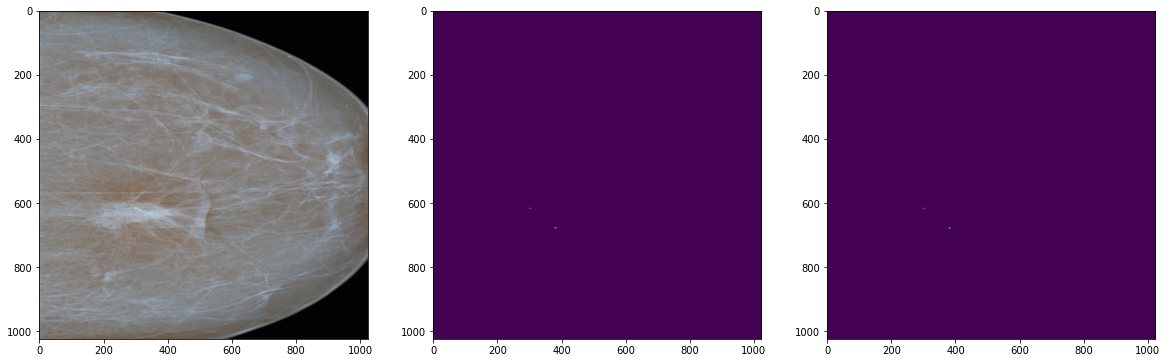

In [ ]:
fig=plt.figure(figsize=(20,20))
fig.add_subplot(131)
plt.imshow(transformed_image)

fig.add_subplot(132)
plt.imshow(transformed_Masks_cal)

fig.add_subplot(133)
plt.imshow(transformed_Masks_mass)


In [ ]:
from keras.regularizers import l2
model = create_model(input_shape, anchors, num_classes)

try:
        model = load_model(model_path, compile=False)
        print('Cant_load')      
       
except:
            model=yolo_body(Input(shape=(None,None,3)), num_anchors//3, num_classes)
            model.load_weights(model_path) 
            print('Ok_here_we_Go_agin')
            # for i in range(len(model.layers)):
            #   model.layers[i].trainable = True
            # print("Unfreeze_all")

Create YOLOv3 model with 9 anchors and 1 classes.
Load weights /content/drive/MyDrive/Colab Notebooks/yolov4/yolov4.h5.
Ok_here_we_Go_agin


In [ ]:
type(model)

keras.engine.functional.Functional

In [ ]:
from keras.preprocessing import image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import load_img, img_to_array
from numpy import expand_dims
from matplotlib import pyplot
from matplotlib.patches import Rectangle

img='/content/drive/MyDrive/Colab Notebooks/yolov4/test/665.png'
input_w, input_h=(416,416)
image, image_w, image_h = load_image_pixels(img, (input_w, input_h))
print(image.shape)

# make prediction
yhat = model.predict(image)
# print(yhat)

# summarize the shape of the list of arrays
print([a.shape for a in yhat])

# define the probability threshold for detected objects
class_threshold = 0.6
boxes = list()

for i in range(len(yhat)):
  # decode the output of the network
  boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)



In [ ]:
# # correct the sizes of the bounding boxes for the shape of the image
# correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
# # suppress non-maximal boxes
# do_nms(boxes, 0.2)
# # define the labels

# labels = ["Handgun", "Knife", "Rifle"]
# # get the details of the detected objects
# v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
# # summarize what we found

# for i in range(len(v_boxes)):
# 	print(v_labels[i], v_scores[i],v_boxes[i].xmin,v_boxes[i].ymin,v_boxes[i].xmax,v_boxes[i].ymax)
# # draw what we found
# draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

In [ ]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/')

In [ ]:
test_txt="/content/drive/MyDrive/Colab Notebooks/test_set.txt"

test=open(test_txt)
test_lines=test.readlines()
for line in test_lines:
  print(line)
  line = line.split(" ")
  print(line,"__________")

if(len(line[1:-1])!=0):
        box=np.array([np.array(list(map(float,boxes.split()))) for boxes in line[1:-1] ])  
        print(box,'******')
      

In [ ]:
from keras.preprocessing import image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
batch_holder = np.zeros((24, 416, 416, 3))
img_dir= '/content/sample_data/data/test/*.png'
for i,img in enumerate(os.listdir(img_dir)):
  img = image.load_img(os.path.join(img_dir,img), target_size=(416,416))
  batch_holder[i, :] = img

In [ ]:
def get_label_name(i):
  if i==[0]:
    pred="Calcification"
  else :
    pred="Non Calcification"

  return pred

In [ ]:
import os
!pwd
os.chdir('/content/')
!pwd

/content/drive/My Drive/Colab Notebooks
/content


In [ ]:
img='/content/drive/MyDrive/Colab Notebooks/yolov4/test/665.png'
im = Image.open(img)
imrs = im.resize((416,416))
imrs=img_to_array(imrs)/255
#imrs=imrs.transpose(2,0,1)
imrs=imrs.reshape(416,416,3)

In [ ]:
pred=model.predict(img)

In [ ]:
result=model.predict_on_batch(batch_holder)

In [ ]:
result[0][1]

In [ ]:
fig = plt.figure(figsize=(20, 20))
for i,img in enumerate(batch_holder):
  fig.add_subplot(4,5, i+1)
  plt.title(get_label_name(result[i]))
  plt.imshow(img/256.)
  
plt.show()

##Detect with img

In [ ]:
def image_preporcess(image, target_size, gt_boxes=None):

          ih, iw    = target_size
          h,  w, _  = image.shape

          scale = min(iw/w, ih/h)
          nw = int(scale * w)
          nh = int(scale * h)
          
          image_resized = cv2.resize(image, (nw, nh), interpolation=cv2.INTER_CUBIC)

          image_paded = np.full(shape=[ih, iw, 3], fill_value=128.0)
          dw, dh = (iw - nw) // 2, (ih-nh) // 2
          image_paded[dh:nh+dh, dw:nw+dw, :] = image_resized

          image_paded = np.array(image_paded, dtype='float32')
          
          image_paded = image_paded / 255.
          
          image_paded = np.expand_dims(image_paded, axis=0)

          return image_paded

In [ ]:
class YOLO(object):
    _defaults = {
        "model_path": '/content/drive/MyDrive/Detection_models/masse_cal_v5.h5',
        "anchors_path": '/content/drive/MyDrive/Colab Notebooks/yolo_anchors.txt',
        "classes_path":  '/content/drive/MyDrive/Colab Notebooks/Classes.txt',
        "score" : 0.3,
        "iou" : 0.45,
        "model_image_size" : (512, 512),
        "text_size" : 3,
        }
    

    def get_defaults(cls, n):
            if n in cls._defaults:
                return cls._defaults[n]
            else:
                return "Unrecognized attribute name '" + n + "'"

    def __init__(self, **kwargs):
            self.__dict__.update(self._defaults) # set up default values
            self.__dict__.update(kwargs) # and update with user overrides
            self.class_names = self._get_class()
            self.anchors = self._get_anchors()
            # self.sess = K.get_session()
            
            self.sess = tf.compat.v1.Session()
            self.boxes, self.scores, self.classes = self.generate()

    def _get_class(self):
            classes_path = os.path.expanduser(self.classes_path)
            with open(classes_path) as f:
                class_names = f.readlines()
            class_names = [c.strip() for c in class_names]
            return class_names

    def _get_anchors(self):
            anchors_path = os.path.expanduser(self.anchors_path)
            with open(anchors_path) as f:
                anchors = f.readline()
            anchors = [float(x) for x in anchors.split(',')]
            return np.array(anchors).reshape(-1, 2)

    def generate(self):
            model_path = os.path.expanduser(self.model_path)
            assert model_path.endswith('.h5'), 'Keras model or weights must be a .h5 file.'

            # Load model, or construct model and load weights.
            num_anchors = len(self.anchors)
            num_classes = len(self.class_names)
            
            try:
                self.yolo_model = load_model(model_path, compile=False)
            except:
                  self.yolo_model=yolo_body(Input(shape=(None,None,3)), num_anchors//3, num_classes)
                  self.yolo_model.load_weights(model_path)
                  # for i in range(len(model.layers)):
                  #     self.yolo_model.layers[i].trainable = True
                  print("Unfreeze_all")
                  print('Ok_here_we_Go_agin')
            else:
                assert self.yolo_model.layers[-1].output_shape[-1] == \
                    num_anchors/len(self.yolo_model.output) * (num_classes + 5), \
                    'Mismatch between model and given anchor and class sizes'

            print('{} model, anchors, and classes loaded.'.format(model_path))

            # Generate colors for drawing bounding boxes.
            hsv_tuples = [(x / len(self.class_names), 1., 1.)
                          for x in range(len(self.class_names))]
            self.colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
            self.colors = list(
                map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
                    self.colors))

            np.random.shuffle(self.colors)  # Shuffle colors to decorrelate adjacent classes.

            # Generate output tensor targets for filtered bounding boxes.
            self.input_image_shape = K.placeholder(shape=(2, ))
            boxes, scores, classes = yolo_eval(self.yolo_model.output, self.anchors,
                    len(self.class_names), self.input_image_shape,
                    score_threshold=self.score, iou_threshold=self.iou)
            return boxes, scores, classes

    def detect_image(self, image):
            if self.model_image_size != (None, None):
                assert self.model_image_size[0]%32 == 0, 'Multiples of 32 required'
                assert self.model_image_size[1]%32 == 0, 'Multiples of 32 required'
                boxed_image = image_preporcess(np.copy(image), tuple(reversed(self.model_image_size)))
                image_data = boxed_image

            out_boxes, out_scores, out_classes = self.sess.run(
                [self.boxes, self.scores, self.classes],
                feed_dict={
                    self.yolo_model.input: image_data,
                    self.input_image_shape: [image.shape[1], image.shape[0]],#[image.size[1], image.size[0]],
                    K.learning_phase(): 0
                })

            print('Found {} boxes for {}'.format(len(out_boxes), 'img'))

            thickness = (image.shape[0] + image.shape[1]) // 600
            fontScale=1
            ObjectsList = []
            
            for i, c in reversed(list(enumerate(out_classes))):
                predicted_class = self.class_names[c]
                box = out_boxes[i]
                score = out_scores[i]

                label = '{} {:.2f}'.format(predicted_class, score)
                #label = '{}'.format(predicted_class)
                scores = '{:.2f}'.format(score)

                top, left, bottom, right = box
                top = max(0, np.floor(top + 0.5).astype('int32'))
                left = max(0, np.floor(left + 0.5).astype('int32'))
                bottom = min(image.shape[0], np.floor(bottom + 0.5).astype('int32'))
                right = min(image.shape[1], np.floor(right + 0.5).astype('int32'))

                mid_h = (bottom-top)/2+top
                mid_v = (right-left)/2+left

                # put object rectangle
                cv2.rectangle(image, (left, top), (right, bottom), self.colors[c], thickness)

                # get text size
                (test_width, text_height), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, thickness/self.text_size, 1)

                # put text rectangle
                cv2.rectangle(image, (left, top), (left + test_width, top - text_height - baseline), self.colors[c], thickness=cv2.FILLED)

                # put text above rectangle
                cv2.putText(image, label, (left, top-2), cv2.FONT_HERSHEY_SIMPLEX, thickness/self.text_size, (0, 0, 0), 1)

                # add everything to list
                ObjectsList.append([top, left, bottom, right, mid_v, mid_h, label, scores])

            return image, ObjectsList

    def detect_img(self, image):
            image = cv2.imread(image, cv2.IMREAD_COLOR)
            #original_image_color=dicom.dcmread('Test_Set/'+'Images/'+image).pixel_array
            # plt.imshow(original_image_color)
            original_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            original_image_color = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
            
            r_image, ObjectsList = self.detect_image(original_image_color)
            return r_image, ObjectsList

In [ ]:
import tensorflow as tf
tf.compat.v1.Session()

In [ ]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
yolo = YOLO(score= 0.3,iou= 0.45)

Unfreeze_all
Ok_here_we_Go_agin
/content/drive/MyDrive/Detection_models/masse_cal_v5.h5 model, anchors, and classes loaded.


In [ ]:
r=random.choice(glob.glob('Test_Set/'+'Images/*')).split("/")[-1]
# fig = plt.figure(figsize=(15, 15))
# fig.add_subplot(121)
# plt.imshow(dicom.dcmread('Test_Set/'+'Images/'+r).pixel_array)
cv2.imwrite('/content/sample_data/sohieb_breast.png',dicom.dcmread('Test_Set/'+'Images/'+r).pixel_array)

TEST_img='/content/sample_data/sohieb_breast.png'
r_image, ObjectsList = yolo.detect_img(TEST_img)
print(ObjectsList)

# dc_test_mask=dicom.dcmread('Test_Set/'+'Masks/'+r).pixel_array

# print("nb calc", len(np.unique(dc_test_mask))-1)

# fig.add_subplot(122)
# plt.imshow(dc_test_mask, cmap="binary")
# plt.show()

In [ ]:
image = '/content/drive/MyDrive/segmentation_models/0/ploted_stats.png'
r_image, ObjectsList = yolo.detect_img(image)
print(ObjectsList)
plt.imshow(r_image)

#Anchor generator

In [ ]:
from os import listdir
from os.path import isfile, join
import argparse
import numpy as np
import sys
import os
import shutil
import random 
import math

width_in_cfg_file = 1024.
height_in_cfg_file = 1024.

In [ ]:
def IOU(x,centroids):
    similarities = []
    k = len(centroids)
    for centroid in centroids:
        c_w,c_h = centroid
        w,h = x
        
        if c_w>=w and c_h>=h:
            similarity = w*h/(c_w*c_h)
            
        elif c_w>=w and c_h<=h:
            similarity = w*c_h/(w*h + (c_w-w)*c_h)
           
        elif c_w<=w and c_h>=h:
            similarity = c_w*h/(w*h + c_w*(c_h-h))
           
        else: #means both w,h are bigger than c_w and c_h 
            similarity = (c_w*c_h)/(w*h)
        similarities.append(similarity) # will become (k,) shape
    return np.array(similarities) 

def avg_IOU(X,centroids):
    n,d = X.shape
    sum = 0.
    for i in range(X.shape[0]):
        #note IOU() will return array which contains IoU for each centroid and X[i] // slightly ineffective, but I am too lazy
        sum+= max(IOU(X[i],centroids)) 
    return sum/n

def write_anchors_to_file(centroids,X,anchor_file):
    f = open(anchor_file,'w')
    
    anchors = centroids.copy()
    print(anchors.shape)

    # for i in range(anchors.shape[0]):
    #     anchors[i][0]*=width_in_cfg_file/32.
    #     anchors[i][1]*=height_in_cfg_file/32.
         

    widths = anchors[:,0]
    sorted_indices = np.argsort(widths)

    print('Anchors = ', anchors[sorted_indices])
        
    for i in sorted_indices[:-1]:
        f.write('%0.2f,%0.2f, '%(anchors[i,0],anchors[i,1]))

    #there should not be comma after last anchor, that's why
    f.write('%0.2f,%0.2f\n'%(anchors[sorted_indices[-1:],0],anchors[sorted_indices[-1:],1]))
    
    f.write('%f\n'%(avg_IOU(X,centroids)))
    

def kmeans(X,centroids,eps,anchor_file):
    
    N = X.shape[0]
    iterations = 0
    k,dim = centroids.shape
    # print(k,dim)
    prev_assignments = np.ones(N)*(-1)    
    iter = 0
    old_D = np.zeros((N,k))
    cpt=0
    # print(centroids)
    # print('__________')
    while True:
        D = [] 
        iter+=1           
        for i in range(N):
            d = 1 - IOU(X[i],centroids)
            # print(d)
            D.append(d)
        D = np.array(D) # D.shape = (N,k)
        # print('D',D)
        print("iter {}: dists = {}".format(iter,np.sum(np.abs(old_D-D))))
        
        #assign samples to centroids 
        assignments = np.argmin(D,axis=1)
        #print('assignments',assignments)
        if (assignments == prev_assignments).all() :
            # print("Centroids = ",centroids)
            write_anchors_to_file(centroids,X,anchor_file)
            return

        #calculate new centroids
        centroid_sums=np.zeros((k,dim),float)
        for i in range(N):
            centroid_sums[assignments[i]]+=X[i]        
        for j in range(k):  
            KARIM=centroid_sums[j]/(np.sum(assignments==j))
            if np.isnan(KARIM.sum()):
              # print(j)
              # print(np.unique(assignments))
              # print('_______')
              # print(centroid_sums)
              # print(centroid_sums[j],(np.sum(assignments==j)))
               centroids[j]=random.choice(X[i])
            else:
              centroids[j] = KARIM
        
        prev_assignments = assignments.copy()     
        old_D = D.copy()
        # print(old_D)
        cpt+=1
        

def main(annotation_dims,output_dir,num_clusters):
 
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
        print("anchors dir created")

    annotation_dims = np.array(annotation_dims)
  
    eps = 0.005
    
    if num_clusters == 0:
        for num_clusters in range(1,11): #we make 1 through 10 clusters 
            anchor_file = join( output_dir,'anchors%d.txt'%(num_clusters))

            indices = [ random.randrange(annotation_dims.shape[0]) for i in range(num_clusters)]
            centroids = annotation_dims[indices]
            kmeans(annotation_dims,centroids,eps,anchor_file)
            print('centroids.shape', centroids.shape)
    else:
        anchor_file = join( output_dir,'anchors%d.txt'%(num_clusters))
        indices = [ random.randrange(annotation_dims.shape[0]) for i in range(num_clusters)]
        centroids = annotation_dims[indices]
        kmeans(annotation_dims,centroids,eps,anchor_file)
        print('centroids.shape', centroids.shape)

In [ ]:
# dicom.dcmread('Train_Set/'+'Masks_cal/'+r).pixel_array
# cal_path='/content/Train_Set/Masks_cal/*.dcm'
# masses_path='/content/Train_Set/Masks_masses/*.dcm'
List_bbx=[]
for p_mask in trange(glob.glob('/content/Train_Set/Masks_cal/*.dcm')):
  mask_cal=dicom.dcmread(p_mask).pixel_array
  List_bbx.append(mask_to_yolo(mask_cal))

In [ ]:
List_bbx

In [ ]:
for p_mask in tqdm(glob.glob('/content/Train_Set/Masks_masses/*.dcm')):
  mask_masse=dicom.dcmread(p_mask).pixel_array
  List_bbx.append(mask_to_yolo(mask_masse))

  0%|          | 0/2772 [00:00<?, ?it/s]

In [ ]:
print(List_bbx)
annotation_=[]

[[[715, 519, 9, 5, 0], [885, 662, 3, 1, 0]], [[982, 361, 1, 1, 0], [619, 199, 1, 1, 0], [283, 359, 1, 1, 0], [884, 227, 1, 1, 0]], [[215, 773, 3, 2, 0], [138, 655, 1, 1, 0], [676, 714, 4, 2, 0], [811, 482, 6, 3, 0], [833, 489, 4, 2, 0], [332, 757, 2, 1, 0], [7, 694, 5, 2, 0], [29, 781, 5, 3, 0]], [[548, 786, 4, 2, 0], [214, 746, 4, 2, 0]], [], [[64, 654, 28, 18, 0], [166, 556, 14, 11, 0]], [[890, 1, 1, 1, 0], [846, 81, 1, 1, 0], [1008, 122, 1, 1, 0], [663, 138, 1, 1, 0], [736, 179, 1, 1, 0], [750, 196, 1, 1, 0], [631, 199, 1, 1, 0], [697, 195, 1, 1, 0], [424, 694, 13, 7, 0], [19, 370, 7, 5, 0], [558, 331, 1, 1, 0], [634, 242, 1, 1, 0], [828, 106, 1, 1, 0]], [], [], [], [[403, 158, 1, 1, 0], [395, 278, 4, 2, 0], [483, 65, 1, 1, 0], [455, 145, 14, 4, 0], [492, 42, 3, 2, 0], [528, 309, 1, 1, 0], [531, 160, 3, 3, 0], [531, 135, 12, 4, 0], [873, 200, 1, 1, 0], [981, 78, 1, 1, 0], [613, 100, 1, 1, 0], [576, 16, 2, 1, 0], [589, 149, 1, 1, 0], [784, 272, 25, 8, 0], [565, 433, 1, 1, 0], [540, 2

In [ ]:
for box in List_bbx:
  # print(box)
  for b in box :
    # print(b[2:4])
     w,h = b[2:4]
    #  print(w,h)
     annotation_.append(tuple(map(float,(w,h))))

print(*annotation_,sep='\n')

In [ ]:
for an in annotation_:
  if an[0]>1024 or an[1]>1024:
    print('yaw kayyyna')

In [ ]:
if __name__=="__main__":
    # filelist= '/content/Inbreast_data/Yolo_data.txt'
    output_dir = '/content/anchors'
    num_clusters=9
    main(annotation_,output_dir,num_clusters)

anchors dir created
iter 1: dists = 199275.09344438964


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in true_divide


iter 2: dists = 52465.42606696307
iter 3: dists = 8411.728497877397
iter 4: dists = 3481.8181751972343
iter 5: dists = 2878.428377701327
iter 6: dists = 2635.2692713139213
iter 7: dists = 1419.378395610339
iter 8: dists = 1056.3746792141628
iter 9: dists = 1472.0629253504565
iter 10: dists = 2428.83692195263
iter 11: dists = 1158.858688674329
iter 12: dists = 631.3592470069398
iter 13: dists = 628.2465070320239
iter 14: dists = 587.7774395565356
iter 15: dists = 991.089534797516
iter 16: dists = 563.9082195518197
iter 17: dists = 513.4937332069413
iter 18: dists = 397.47348718929885
iter 19: dists = 327.54780086306073
iter 20: dists = 240.1963417156186
iter 21: dists = 248.1839252354553
iter 22: dists = 105.89684154168565
iter 23: dists = 36.25694596906614
(9, 2)
Anchors =  [[  1.24372258   1.01633529]
 [  4.47917823   2.39658523]
 [ 10.17607128   5.25880356]
 [ 19.82299031   9.97826656]
 [ 46.43113772  22.31257485]
 [112.96835443  53.33333333]
 [213.2408377  107.32984293]
 [360.921259

In [ ]:
anchors=get_anchors('/content/anchors/anchors9.txt')
diff=512/1024
print(diff)
for anchor in anchors:
  # print(anchor)
  anchor[0]=anchor[0]*diff
  anchor[1]=anchor[1]*diff
  # print(anchor)

0.5


In [ ]:
anchors

array([[  0.62 ,   0.51 ],
       [  2.24 ,   1.2  ],
       [  5.09 ,   2.63 ],
       [  9.91 ,   4.99 ],
       [ 23.215,  11.155],
       [ 56.485,  26.665],
       [106.62 ,  53.665],
       [180.46 ,  96.915],
       [287.555, 181.29 ]])

In [ ]:
to_run = True 

In [ ]:
if to_run:
  !git clone https://github.com/AntonMu/TrainYourOwnYOLO
  %cd TrainYourOwnYOLO
  !pip install -r requirements.txt
  to_run = False
  # !wandb login

In [ ]:
%cd 2_Training
!python Download_and_Convert_YOLO_weights.py